In [1]:
import numpy as np   # import needed libraries
import pandas as pd
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
from scipy.signal import argrelextrema

# PERIOD FUNCTION

In [2]:
# Function to read in a dataframe column of spider data (a series) and the interval between measurements
# in minutes and, to return the period (in minutes) and the power from the Lomb-Scargle periodogram method
# Note that the variables start_index and end_index were set by trial and error, and could need adjustment
# if the results for period and power seem questionable. 

# Now expanded to also read in a file_base string and a spider_string (with a spider number in the form 's#' typically),
# and save a png file of the calculated LS Periodogram. Also now returns a 'false alarm probability', which estimates
# the chance that the peak maximum observed in the periodogram could arise by random chance if the data were Gaussian
# noise with no periodic component

def Function_LS_Deluxe(file_base,spider_string,series,min_interval):  # set min_interval to the time between measurements in minutes

    steps = len(series)    # find number of items in the input spider data
    time_input = np.linspace(1,steps,num=steps)  # create a time grid for the LombScargle routine
#    ls = LombScargle(time_input, series, normalization='standard') # calculate LombScargle p-gram and put in object 'ls'
#    ls = LombScargle(time_input, series, normalization='model') # calculate LombScargle p-gram and put in object 'ls'
#    ls = LombScargle(time_input, series, normalization='log') # calculate LombScargle p-gram and put in object 'ls'
    ls = LombScargle(time_input, series, normalization='psd') # calculate LombScargle p-gram and put in object 'ls'
    min_freq = 1./(34.*60.) * min_interval
    max_freq = 1./(14.*60.) * min_interval
#    print(min_freq, max_freq)
    frequency, power = ls.autopower(minimum_frequency=min_freq,maximum_frequency=max_freq,samples_per_peak=50)  
                                # extract the frequency and power arrays with specified frequency limits and grid spacing
    period = 1./frequency * min_interval / 60.  # create an array of periods from the array of frequencies
    max_power = np.amax(power, axis = 0)  # find the value of the maximum power within restricted range
    extrema=power[argrelextrema(power, np.greater)]
    maximum1 = max(extrema)
    maximum2 = max(extrema, key=lambda x: min(extrema)-1 if (x == maximum1) else x)
    print(maximum2)
    period_second_hr= np.abs(1/(frequency[np.where(power == maximum2)]))*min_interval / 60
    period_max_hr = np.abs(1/(frequency[np.where(power == max_power)]))*min_interval / 60.  # locate 
                                                                        # period where max power occurs and express in hours
    false_alarm_prob = ls.false_alarm_probability(max_power) # extract the false alarm probability for peak with height max_power
    plt.figure()    # create periodogram figure
    title_string = spider_string 
    filename = spider_string+'.png'   # construct output filename for the periodogram 
    plt.title(title_string)   # set title
    plt.xlabel("Period (hr)")  # set x-axis label
    plt.ylabel("Lomb-Scargle Amplitude") # set y-axis label
    plt.plot(period,power,linewidth=2)  # plot the periodogram
    plt.plot(period_max_hr,max_power,color='red',marker='o')  # put a circular point at the max peak
    plt.plot(period_second_hr,maximum2,color='blue',marker='o')
    #plt.savefig(filename,dpi=300)  # save the periodogram file
    plt.ion()
    plt.show()  # close the periodogram figure
    #return (period_max_hr.item(), max_power, false_alarm_prob)  # returns period, max_power, false_alarm as floating points
    return (period_max_hr.item(), max_power, false_alarm_prob)

In [3]:
# Function to take in base filenames (i.e., with '.csv' stripped off) of spider data and spider metafile  
# (with Alive/Circadian specified) and to return a dataframe of only the Alive/Circadian spiders with their 
# Periods/Amplitudes/False Alarm Probabilities using the Lomb-Scargle Periodogram method from astropy. 
# Each spider also has a periodogram output as a 300-dpi .png file.
# Note this function calls the function Function_LS_Deluxe in the above cell

def LS_Period_Amplitude_FalseAlarm_Pgram(spider_datafile_base):
    spider_data_filename = spider_datafile_base + '.csv'  # reconstruct spider data full filename
    df_spider = pd.read_csv(spider_data_filename, index_col=0) # read in all the spider data from the given filename
    df_spider.index = pd.to_datetime(df_spider.index)            # reset indexes to datetime format for convenience
    spiderac_list_all = df_spider.columns.values.tolist()       # extract list of all column names from dataframe
    spiderac_list =  spiderac_list_all[1:]                      #  restrict list to column names that are spider names
    output_columns = ['Spider','Period','Amplitude','p value']    # prepare column names for the output dataframe
    df_output = pd.DataFrame(columns = output_columns)  # create an empty dataframe with the output column names
    for spider_name in spiderac_list:             # loop over the names of the alive/circadian spiders
        column_name = spider_name                 # set the current column name within the spider dataframe 
#        df_spider[column_name] = df_spider[column_name].fillna(0)  # replace any stray values with zeroes to prevent errors
        column = df_spider[column_name]           # get the column (series) data for the current spider
#        print(type(column))
#        print(spider_name, ' ',column.max())
#        if (column.max()>0):  # prevent error that occurs when series of data is all zero
        dt = df_spider.index.minute[1]-df_spider.index.minute[0]  # use the datetime format to find measurement interval
        pmax, amp, false_alarm = Function_LS_Deluxe(spider_datafile_base,spider_name,column,dt) 
                                                    # call above function to find period, max power, and false alarm probability
#        else:
#            pmax, amp, false_alarm = [0.0,0.0,1.0]
        df_add = pd.DataFrame([[spider_name,pmax,amp,false_alarm]],columns=output_columns)  # prepare a row to be added to the output dataframe
        df_output = df_output.append(df_add, ignore_index = True)     # add a row to the output datafram
    return(df_output)                             # return the full output dataframe

131.43348652575


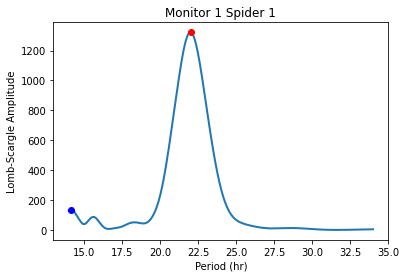

397.74800462665655


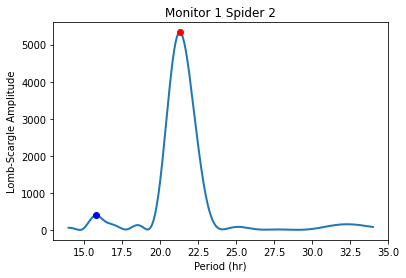

1061.15646614728


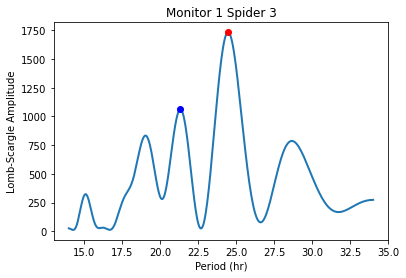

947.590859245099


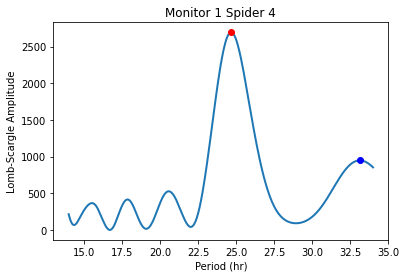

635.9744284543098


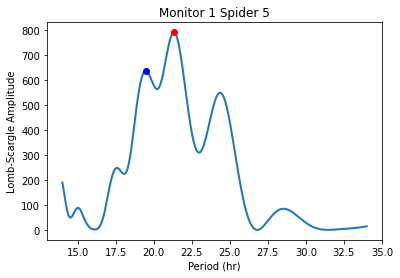

157.40711769562242


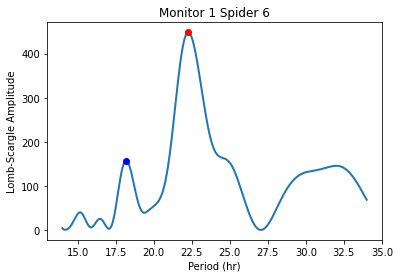

365.5098060055597


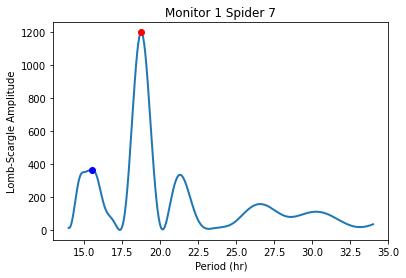

224.84001436969754


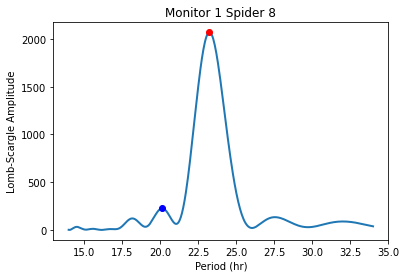

467.91282180739444


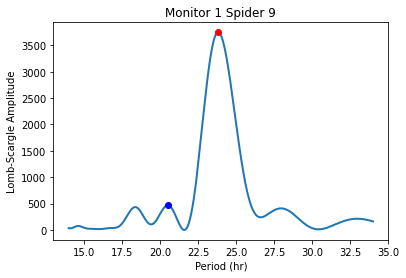

412.9405848569479


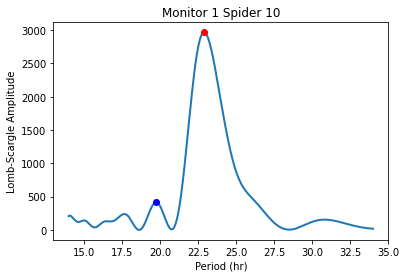

176.61786097308118


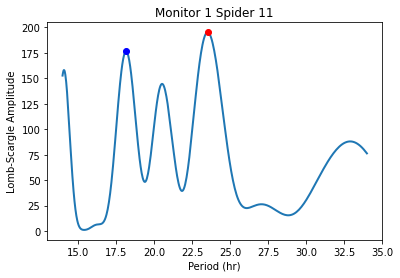

219.46031246304767


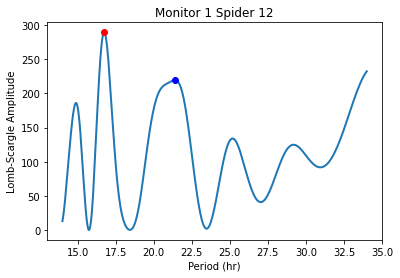

299.4118954857123


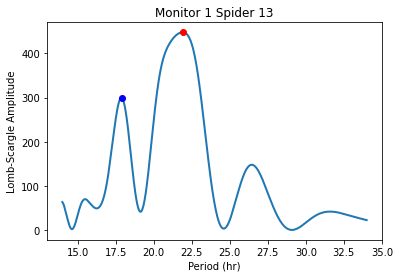

78.00649419357572


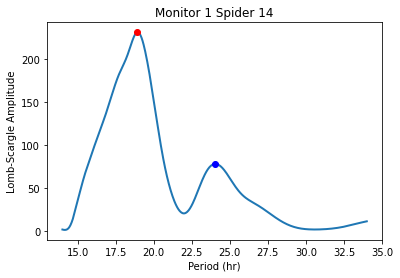

244.57903409294966


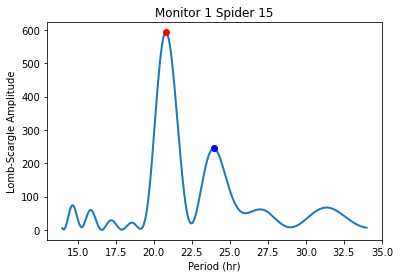

157.1385877684251


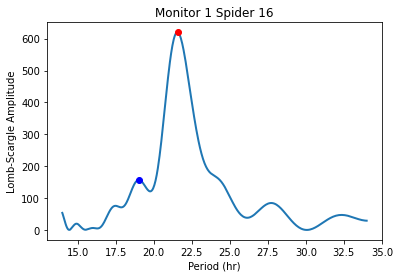

275.37502964354815


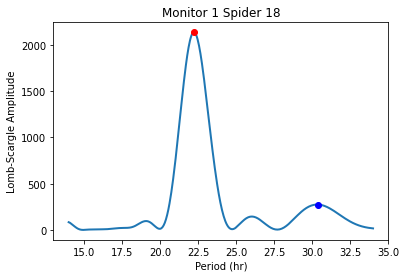

736.457940484809


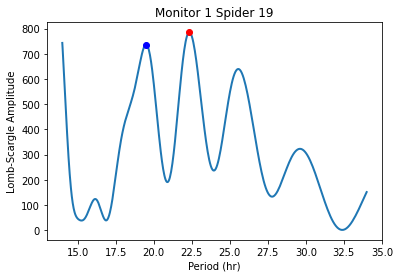

62.09778214222689


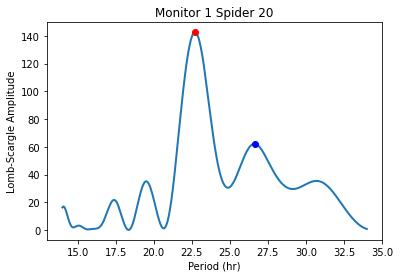

67.65549297208463


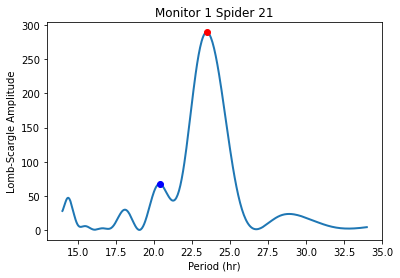

170.2458053324155


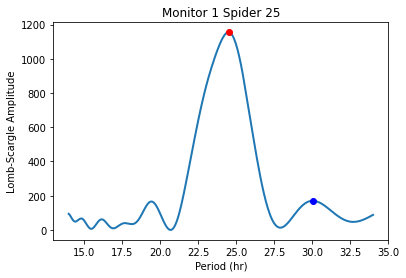

104.24128292962726


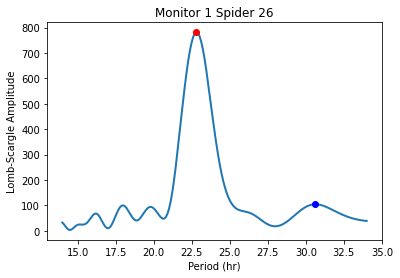

333.7940933073327


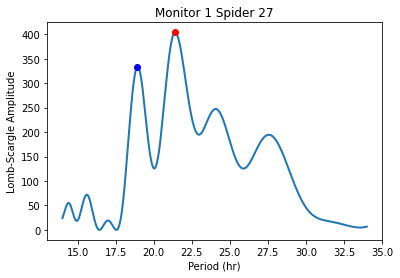

218.1104488680399


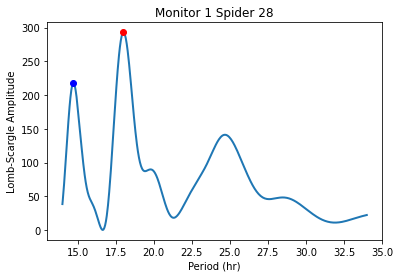

107.46168031762971


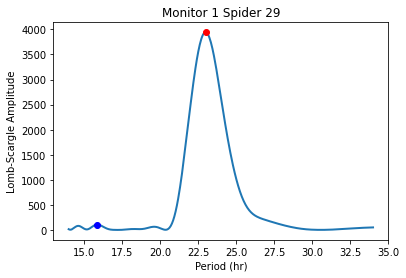

426.603722558022


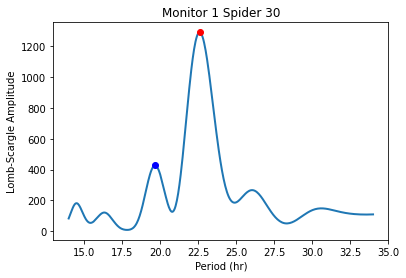

428.28183166545523


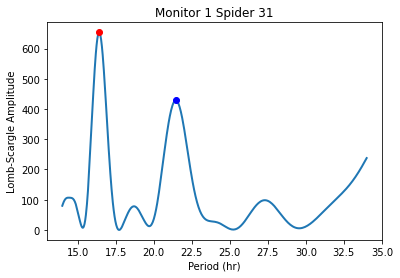

943.9146448707908


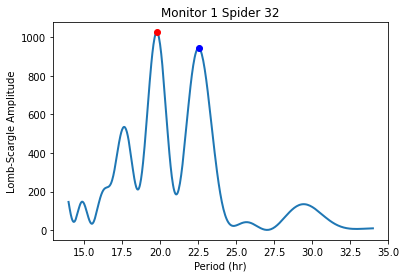

Period    Amplitude  p value
Spider                                             
Monitor 1 Spider 1  22.011150  1322.464061      0.0
Monitor 1 Spider 2  21.316001  5333.174854      0.0
Monitor 1 Spider 3  24.453386  1734.088370      0.0
Monitor 1 Spider 4  24.676897  2695.489814      0.0
Monitor 1 Spider 5  21.316001   790.538587      0.0

In [4]:
spider_datafile_base = "Metazygia monitor 1_DD"       # specify the base filename for the set of spiders                       
df_out = LS_Period_Amplitude_FalseAlarm_Pgram(spider_datafile_base)
   # get the dataframe with Lomb-Scargle periodogram data, while outputting .png periodograms for each spider
df_out = df_out.set_index('Spider')     # reformat the index column in the dataframe
outfile = spider_datafile_base + '_Stats.csv'  # create the output filename for the dataframe with Lomb-Scargle stats
#df_out.to_csv(outfile)                # output the dataframe to file
display(df_out.head())                       # show the dataframe below

In [5]:
day=60*24
minusone=pd.read_csv('Metazygia monitor 1_DD.csv',index_col=0)
minusone=minusone.iloc[day:]
minusone.to_csv('Metazygia monitor 1_DD-MINUS DAY 1.csv') 

minustwo=pd.read_csv('Metazygia monitor 1_DD.csv', index_col=0)
minustwo=minustwo.iloc[(2*day):]
minustwo.to_csv('Metazygia monitor 1_DD-MINUS DAY 1 AND 2.csv') 


52.70107168665398


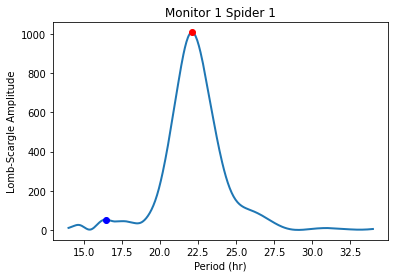

303.79521373734684


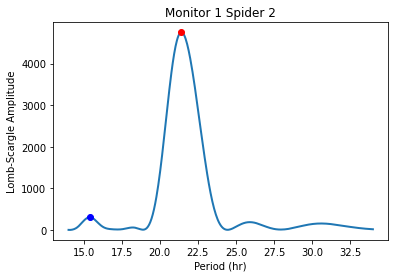

456.4634136513412


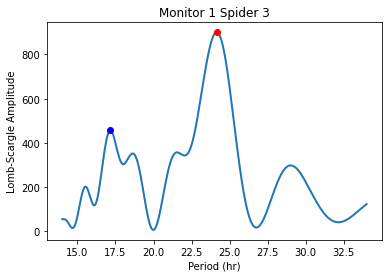

643.6496243031254


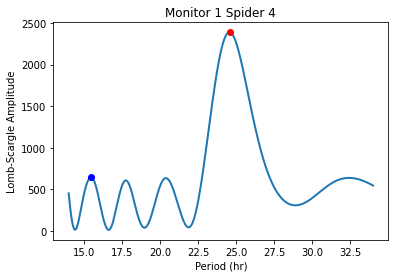

401.86581403042857


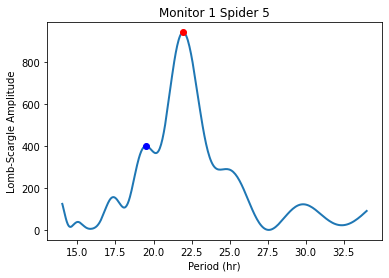

129.00546249418713


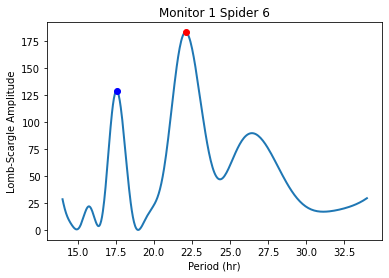

253.41596650897205


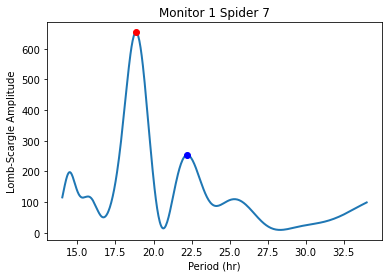

164.5492601111882


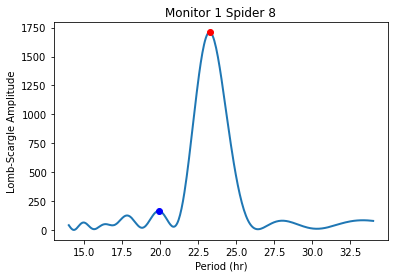

458.43594388264233


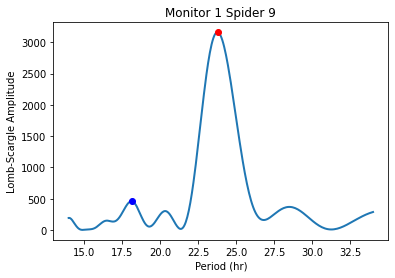

197.47803160970795


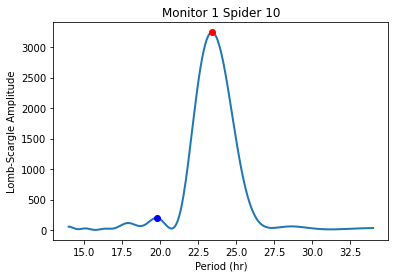

182.73831942296638


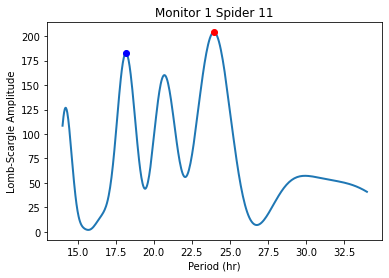

224.7450665340655


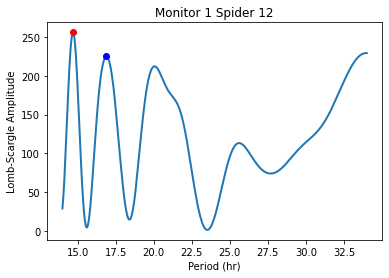

270.4692504320736


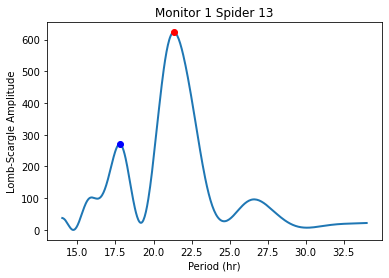

87.8404078950421


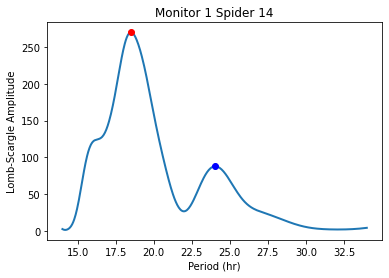

107.30198091188846


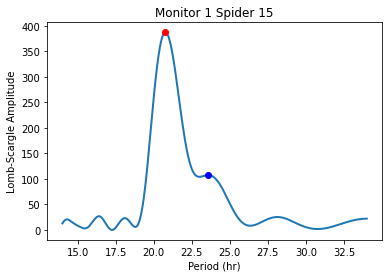

118.62266064446713


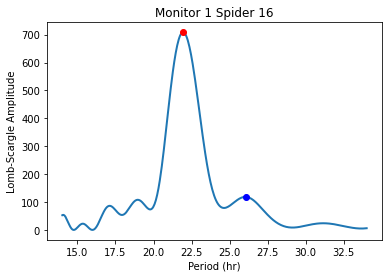

288.20065555177723


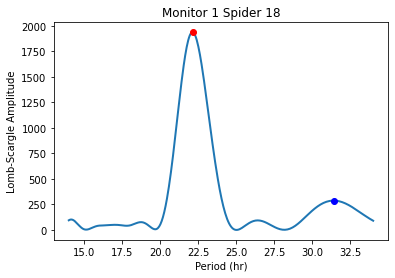

610.3237481958519


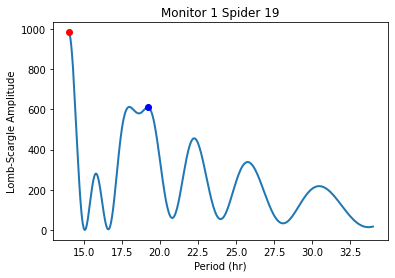

46.09147327222345


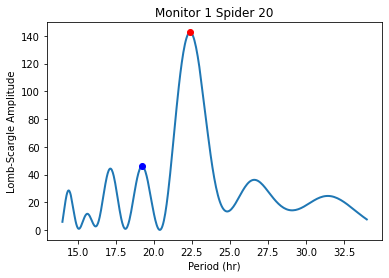

68.61683750702325


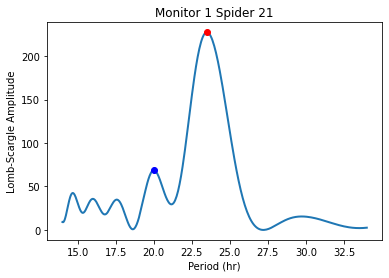

249.82920093187033


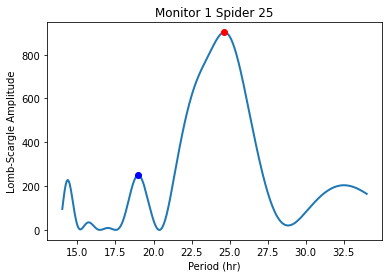

144.17015991637967


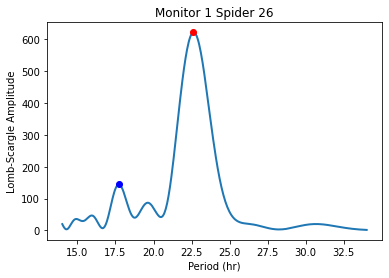

299.264587610305


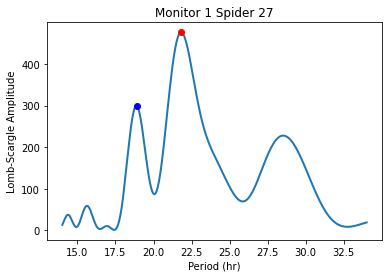

100.04326966814612


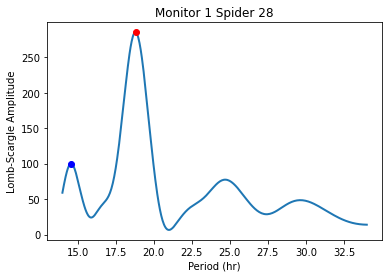

202.29475995189958


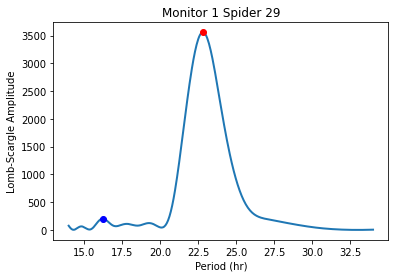

449.3475512873638


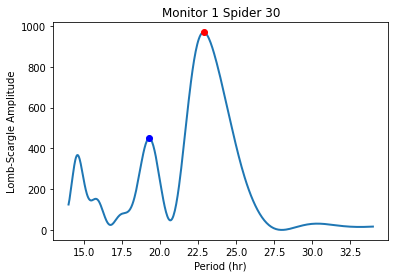

354.57631292729764


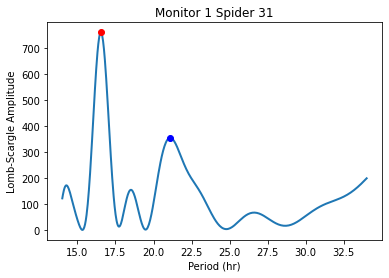

133.2651796809504


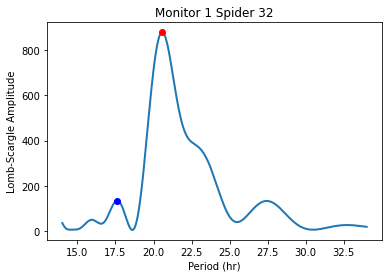

Period    Amplitude  p value
Spider                                             
Monitor 1 Spider 1  22.101170  1010.056873      0.0
Monitor 1 Spider 2  21.411015  4755.658497      0.0
Monitor 1 Spider 3  24.159275   900.356893      0.0
Monitor 1 Spider 4  24.592538  2388.728546      0.0
Monitor 1 Spider 5  21.949560   944.353335      0.0

In [6]:
spider_datafile_base = "Metazygia monitor 1_DD-MINUS DAY 1"       # specify the base filename for the set of spiders                       
df_outone = LS_Period_Amplitude_FalseAlarm_Pgram(spider_datafile_base)
   # get the dataframe with Lomb-Scargle periodogram data, while outputting .png periodograms for each spider
df_outone = df_outone.set_index('Spider')     # reformat the index column in the dataframe
outfile = spider_datafile_base + '_Stats.csv'  # create the output filename for the dataframe with Lomb-Scargle stats
#df_outone.to_csv(outfile)                # output the dataframe to file
display(df_outone.head())                       # show the dataframe below

69.15823102794367


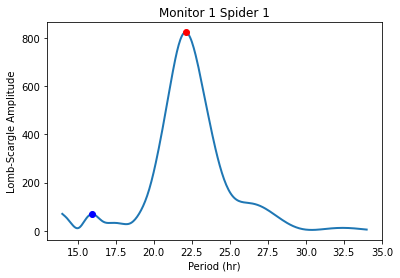

213.04974957912526


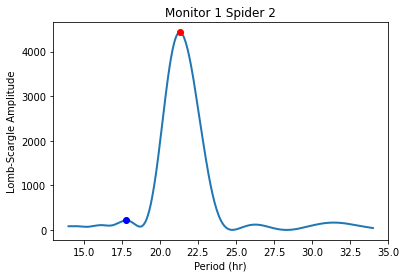

225.68022470855666


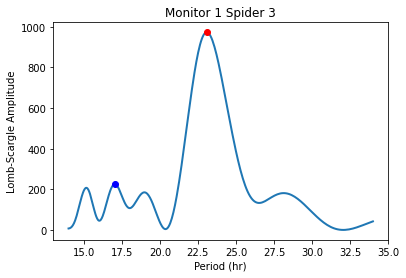

760.59620698629


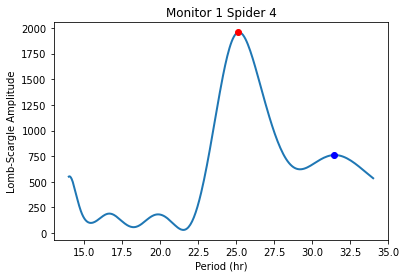

196.96482526908318


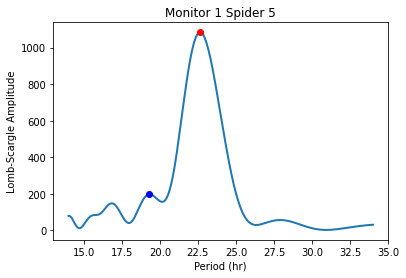

136.78573838004084


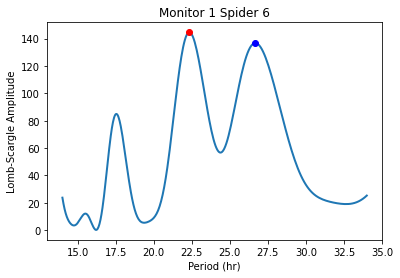

196.85300531591386


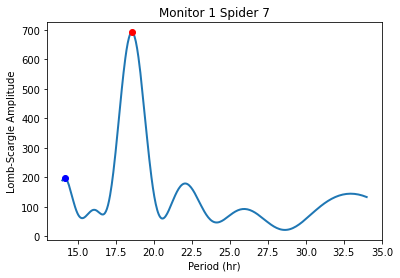

52.31527827138896


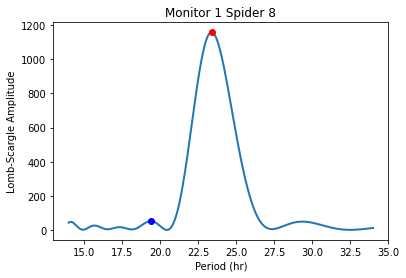

261.0313600281955


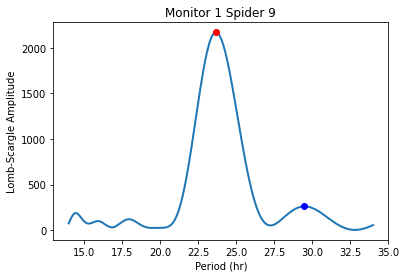

290.07931238924215


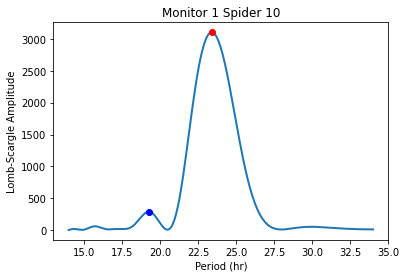

199.87272809971486


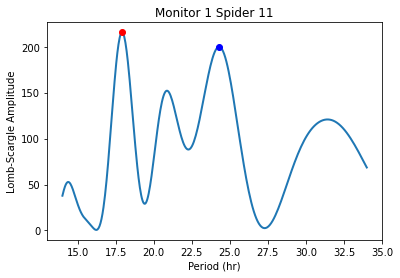

337.5197296672354


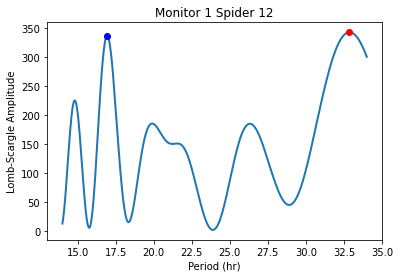

297.9582579540567


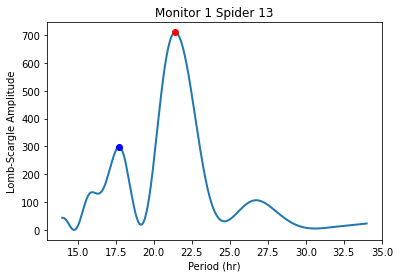

100.36083332001323


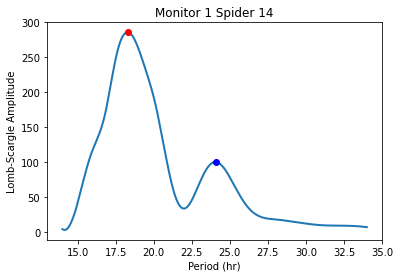

47.274814707939996


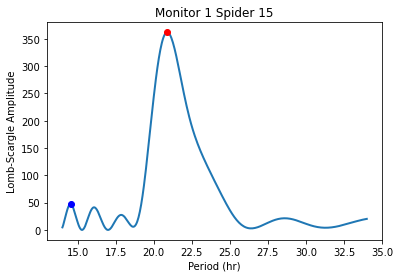

145.68049007597443


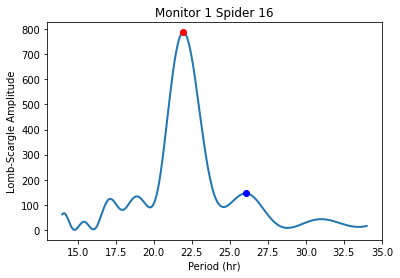

165.04831257466088


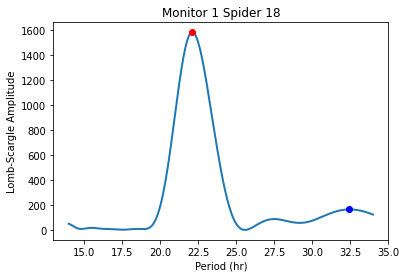

210.74072459782482


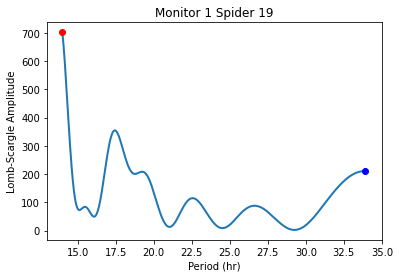

18.099896832370547


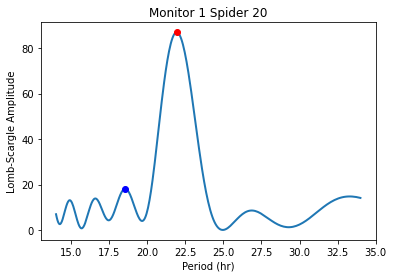

47.954184711581625


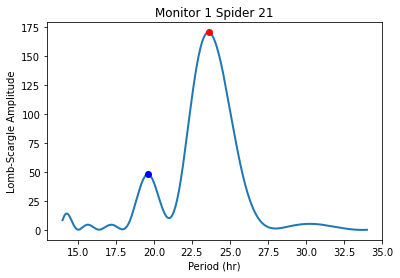

319.68833166688466


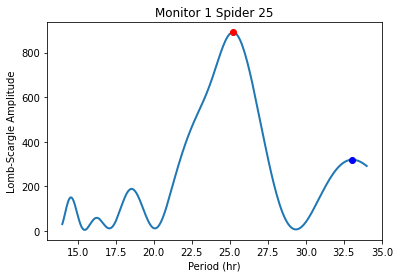

126.25276878916014


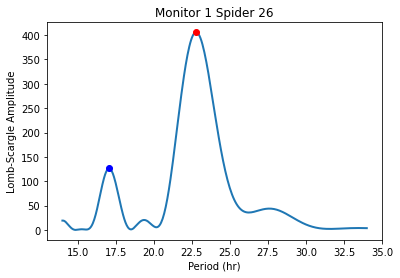

231.8165864249988


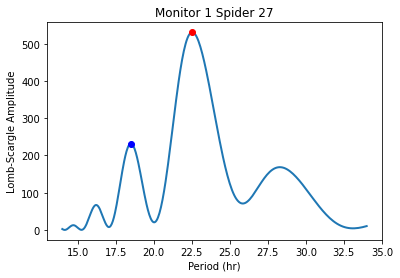

119.36982773504475


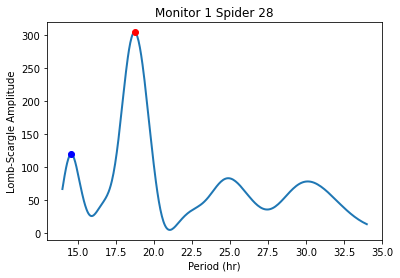

164.8411882693638


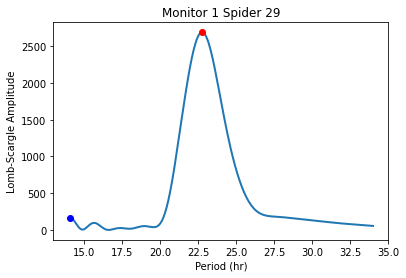

222.02513333388686


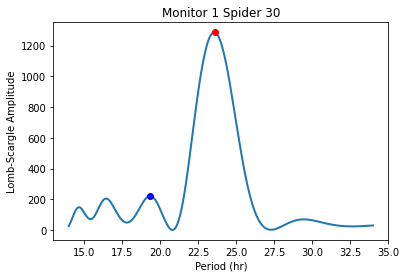

510.04195383562205


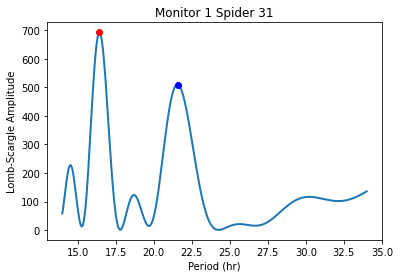

128.0599784649697


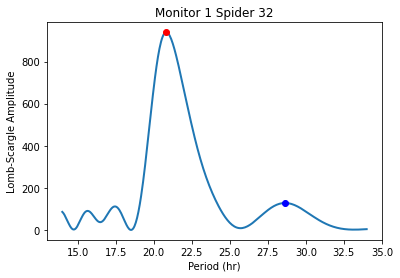

Period    Amplitude  p value
Spider                                             
Monitor 1 Spider 1  22.101074   823.454875      0.0
Monitor 1 Spider 2  21.315825  4434.849359      0.0
Monitor 1 Spider 3  23.072459   973.136330      0.0
Monitor 1 Spider 4  25.144622  1958.630422      0.0
Monitor 1 Spider 5  22.637170  1084.180758      0.0

In [7]:
spider_datafile_base = "Metazygia monitor 1_DD-MINUS DAY 1 AND 2"       # specify the base filename for the set of spiders                       
df_outtwo = LS_Period_Amplitude_FalseAlarm_Pgram(spider_datafile_base)
   # get the dataframe with Lomb-Scargle periodogram data, while outputting .png periodograms for each spider
df_outtwo = df_outtwo.set_index('Spider')     # reformat the index column in the dataframe
outfile = spider_datafile_base + '_Stats.csv'  # create the output filename for the dataframe with Lomb-Scargle stats
#df_out.to_csv(outfile)                # output the dataframe to file
display(df_outtwo.head())                       # show the dataframe below

# RASTER FUNCTION

In [8]:
#Create uniform y-axis limit
def create_ylimit(df):
    #find the standard deviation and mean of each column from the dataset without zeros
    df_limit=df.replace(0, np.nan)
    std=df_limit.std()
    mean=df_limit.mean()
    #Find mean and standard deviation of all of the data
    df_mean=np.mean(mean)
    df_std =np.mean(std)
    #y limit = mean of the dataframe plus 3 standard deviations
    y_limit = df_mean +3*df_std
    return y_limit

def plot_night_test(df):
    #Make a copy of the dataframe and create two columns for the difference between the light values and for the date and time
    dfc = df.copy()
    dfc['diff'] = dfc.lights.diff()
    dfc=dfc.reset_index()
    dfc[["day", "time"]] = dfc["Date_Time"].str.split(" ", expand = True)
    #Separate by the difference to determine when the light is coming on or going off
    df_off = dfc.loc[dfc['diff'] == 1]
    df_on = dfc.loc[dfc['diff'] == -1]
    #Assign variable from the lists
    start1 = dfc.time.values[0]
    end1 = df_off.time.values[0]
    start2 = df_on.time.values[0]
    end2 = dfc.time.values[-1]

    return start1, start2, end1, end2

#Plot activity in subplots
#Imput:Dataframe, List of spiders in df, Specific Spider from list, 
#Label for subplots, variable from "create_ylimit" funnction 
#All variables will be named in final raster plot function
def plot_raster( df, column, spider, ax, y, num_days, min_day): 
    for i in range(0,num_days):
        #Separate dataframe into sections of 1440 minutes(minutes in a day) and plot the 
        #activity for each day
        df.reset_index()
        ax[i].plot(df.index[min_day*i:min_day*(i+1)], df[column[spider]][min_day*i:min_day*(i+1)], color='blue')
        #Label each day
        ax[i].set_ylabel('Subj. Day '+str(i+1))
        #ax[i].set_ylabel(df.day[min_day*i])
        ax[i].set_xticks([])
        # the y limit is the mean plus 3 standard deviations
        ax[i].set_ylim(0,y)
        #setting instructions for shading the graph when the lights are off
        df1=df[min_day*(i):min_day*(i+1)]
        df1=df1.reset_index()
    
        #Make DD plots all grey
        if np.mean(df1.lights)==0:
            ax[i].set_facecolor("silver")
        #Run function to determine when lights are off during LD cycle
        else:
            start1, start2, end1, end2 = plot_night_test(df1)
            ax[i].axvspan(start1, end1, color='silver')
            ax[i].axvspan(start2, end2, color='silver')
            
#Combine all funtions to make raster plots for all spiders given a data frame and list of spiders
def spider_raster(df, per):
    column=df.columns[1:]
    perT = per.T
    #create a copy and separate the date and time for reference
    df_time = df.copy()
    df_time=df_time.reset_index()
    df_time[["day", "time"]] = df_time["Date_Time"].str.split(" ", expand = True)
    #for loop for creating figures for the number of spiders in the dataframe
    for spider in  range(len(column)):
        #Determine length of usable data for each spider
        dftest=df[column[spider]].dropna()
        print(column[spider])
        min_day = int((perT[column[spider]].values) * 60)
        #sub_mins_day = per.iloc[0]['A']
        #print(min_day)
        total_time = len(df.index)
        num_days = total_time//min_day
        #Plot subplots
        fig, ax=plt.subplots(num_days,1, figsize=(8,12), sharey=True)
        fig.suptitle('The Free Running Period of: ' + column[spider], fontsize=16)        
        #setting the y axis limit
        y = create_ylimit(df) 
        #plotting the raster plots
        plot_raster(df_time, column, spider, ax, y, num_days, min_day)
        #plot x axis
        x=int(len(df.index)/4)
        ax[num_days-1].set_xticks([0,x,2*x,3*x,4*x],['0:00','6:00','12:00','18:00','24:00'])
        plt.xlabel('Subjective Time')
        #save figure
        #fig.savefig(column[spider] +'raster_DD_Period')
        #plt.show()
        print('Next spider')

In [9]:
df=pd.read_csv('Metazygia monitor 1_DD.csv', index_col=0)

column=df.columns[1:]
perone=pd.DataFrame(data= df_outone['Period'],index=column)
pertwo=pd.DataFrame(data= df_outtwo['Period'],index=column)
per=pd.DataFrame(data=df_out['Period'],index=column)

Monitor 1 Spider 1
Next spider
Monitor 1 Spider 2
Next spider
Monitor 1 Spider 3
Next spider
Monitor 1 Spider 4
Next spider
Monitor 1 Spider 5
Next spider
Monitor 1 Spider 6
Next spider
Monitor 1 Spider 7
Next spider
Monitor 1 Spider 8
Next spider
Monitor 1 Spider 9
Next spider
Monitor 1 Spider 10
Next spider
Monitor 1 Spider 11
Next spider
Monitor 1 Spider 12
Next spider
Monitor 1 Spider 13
Next spider
Monitor 1 Spider 14
Next spider
Monitor 1 Spider 15
Next spider
Monitor 1 Spider 16
Next spider
Monitor 1 Spider 18
Next spider
Monitor 1 Spider 19
Next spider
Monitor 1 Spider 20
Next spider
Monitor 1 Spider 21
Next spider
Monitor 1 Spider 25
Next spider
Monitor 1 Spider 26


<ipython-input-8-4dc8525d025d>:79: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax=plt.subplots(num_days,1, figsize=(8,12), sharey=True)


Next spider
Monitor 1 Spider 27
Next spider
Monitor 1 Spider 28
Next spider
Monitor 1 Spider 29
Next spider
Monitor 1 Spider 30
Next spider
Monitor 1 Spider 31
Next spider
Monitor 1 Spider 32
Next spider


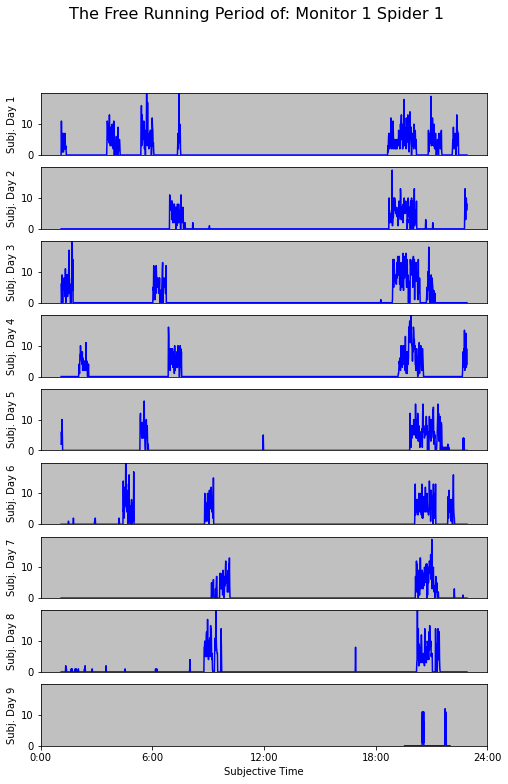

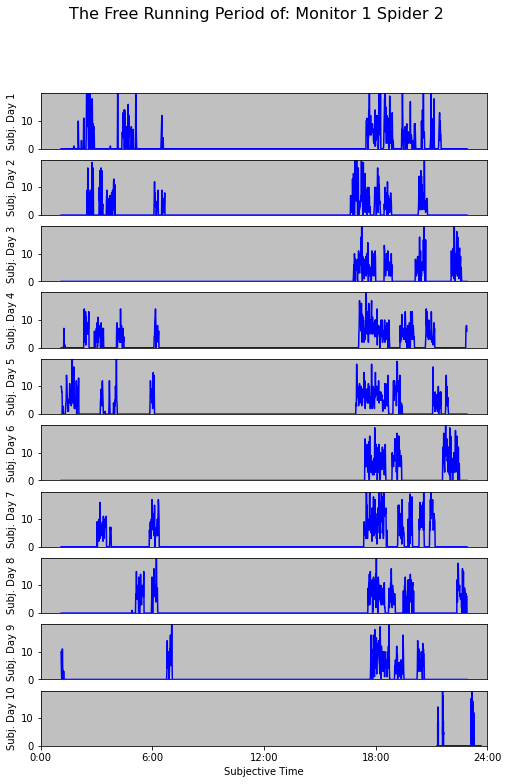

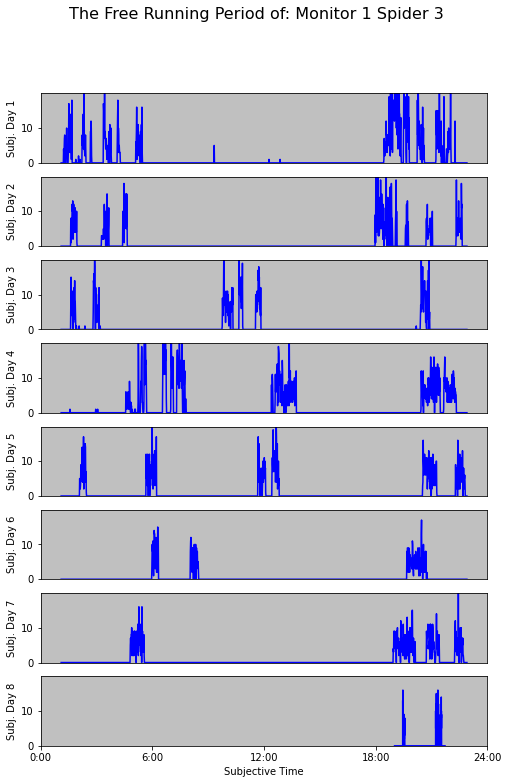

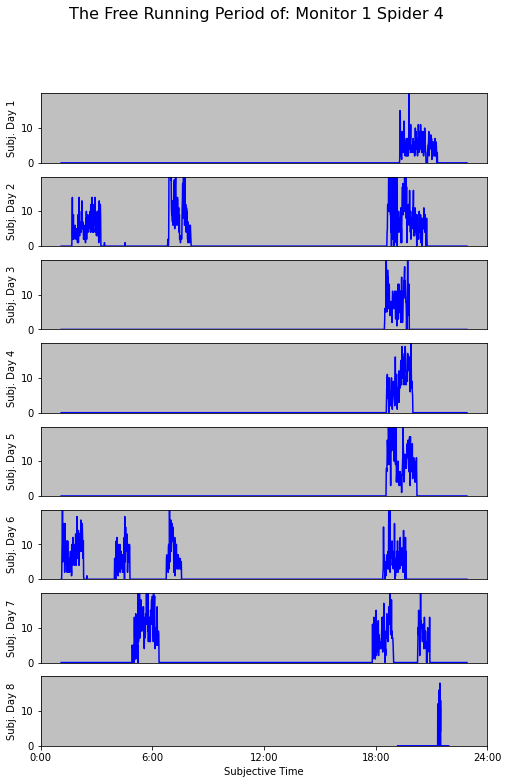

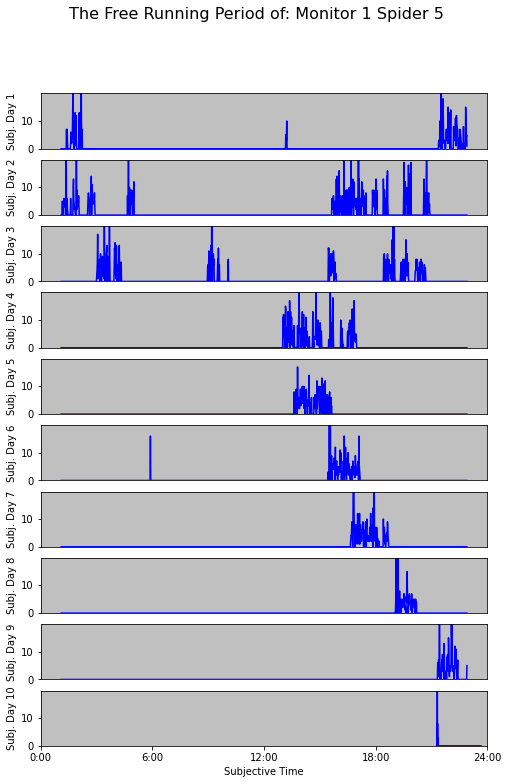

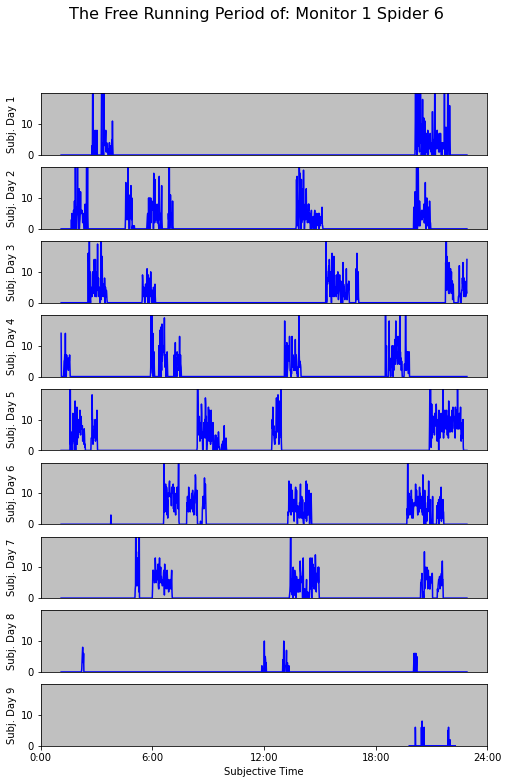

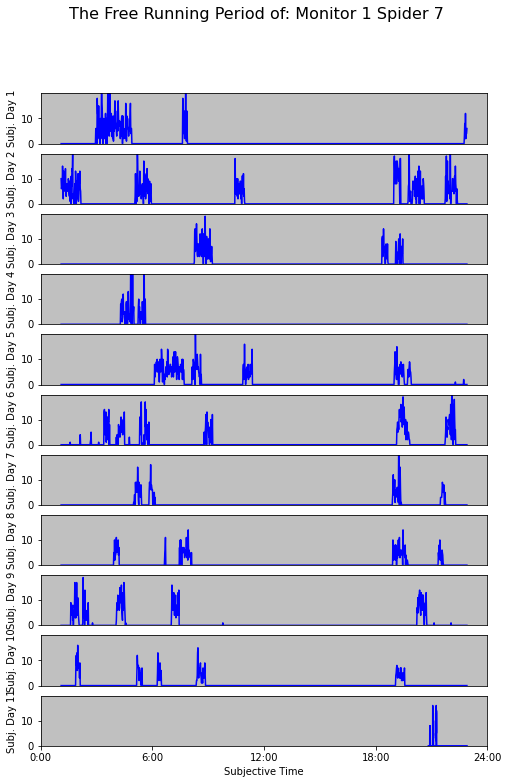

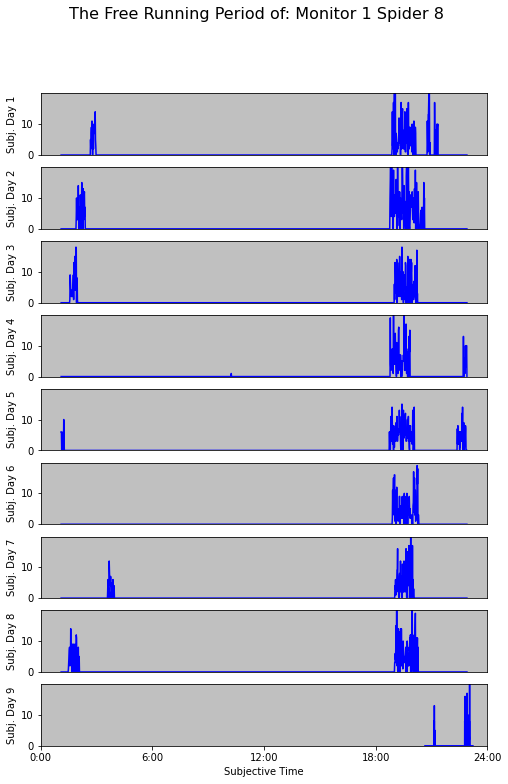

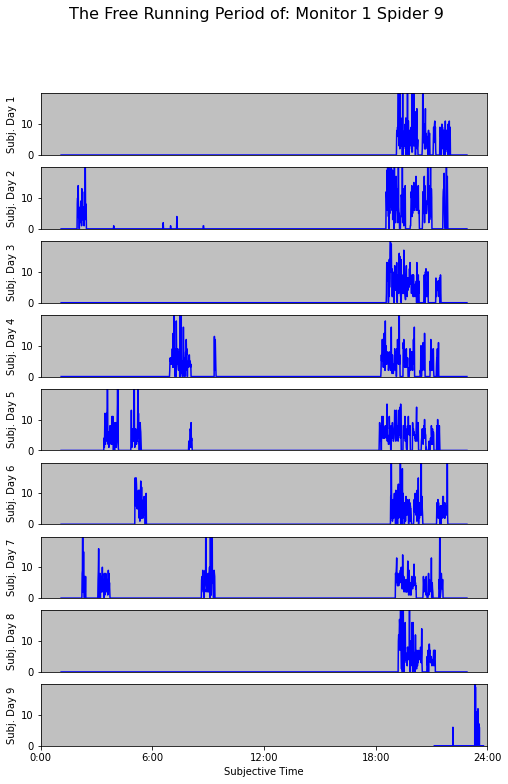

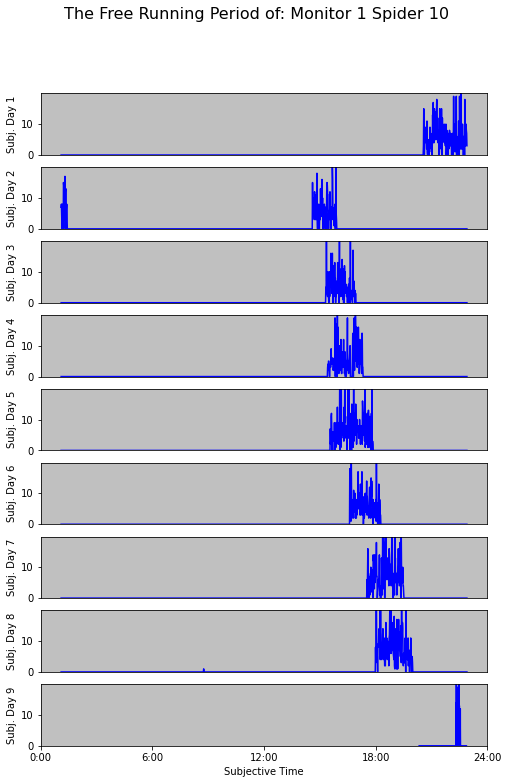

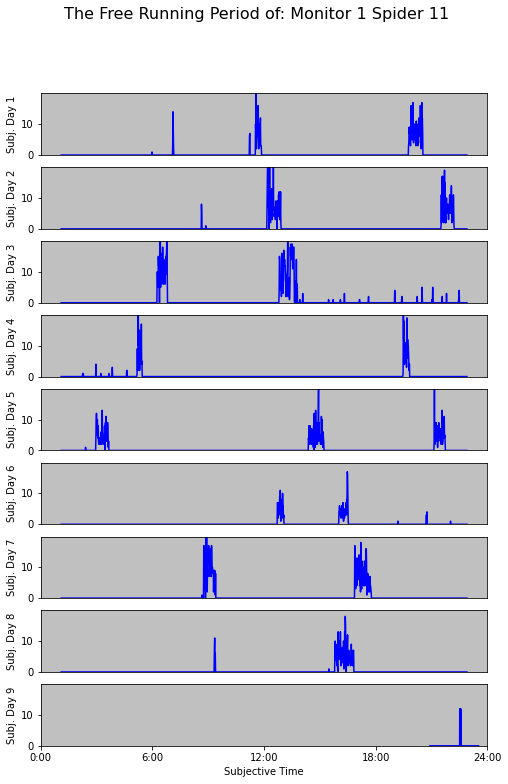

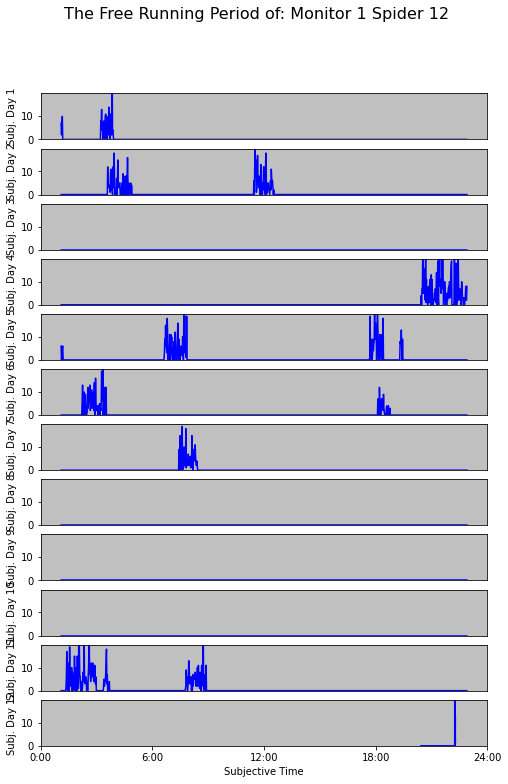

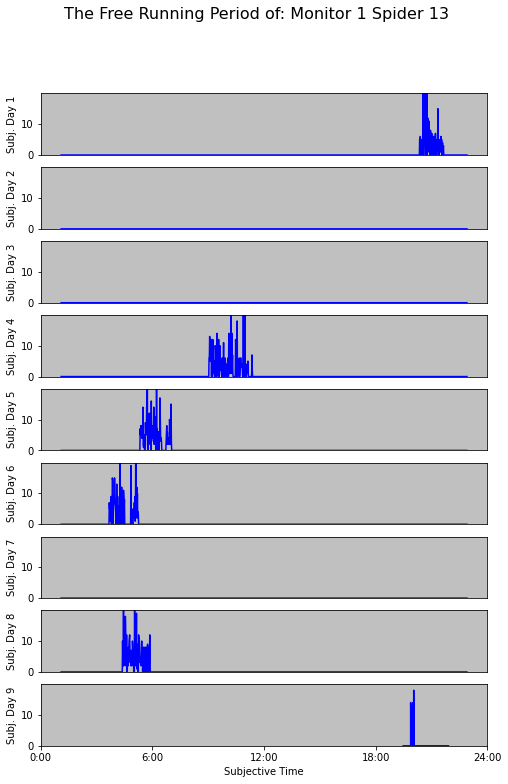

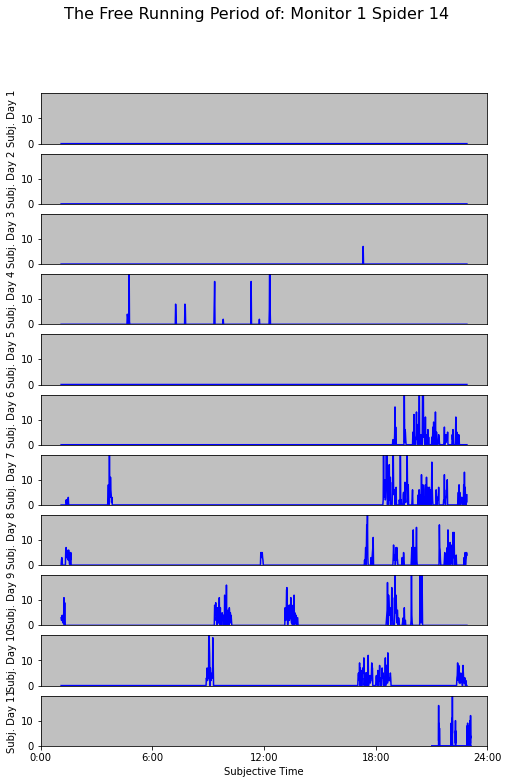

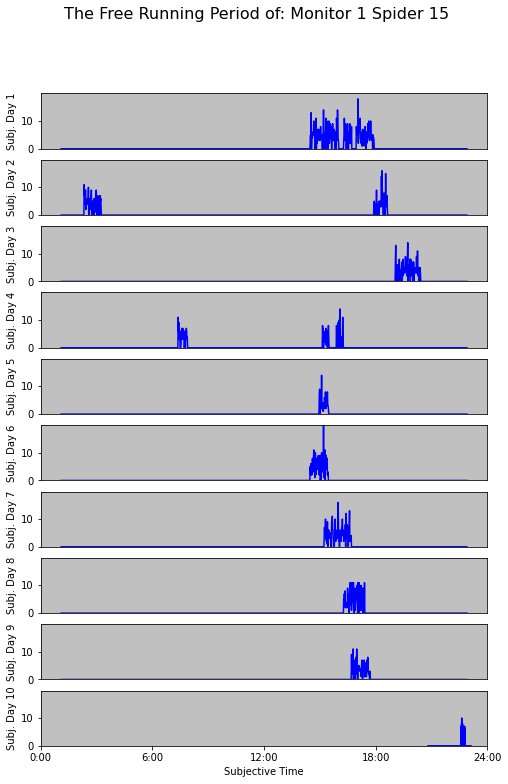

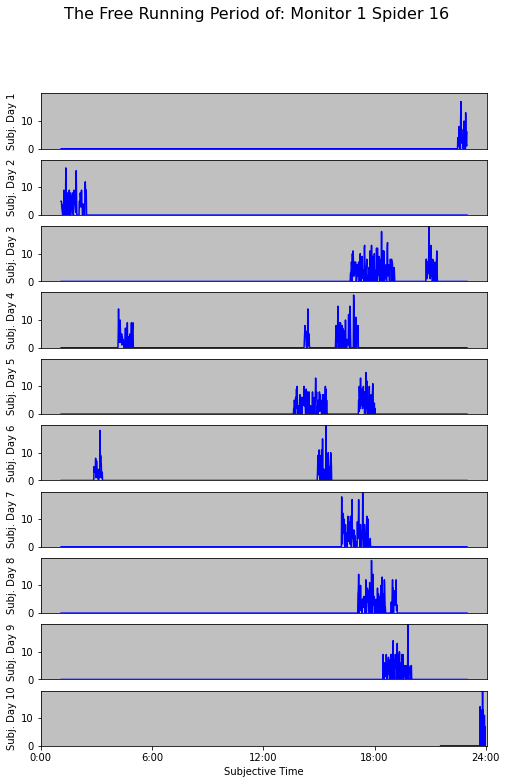

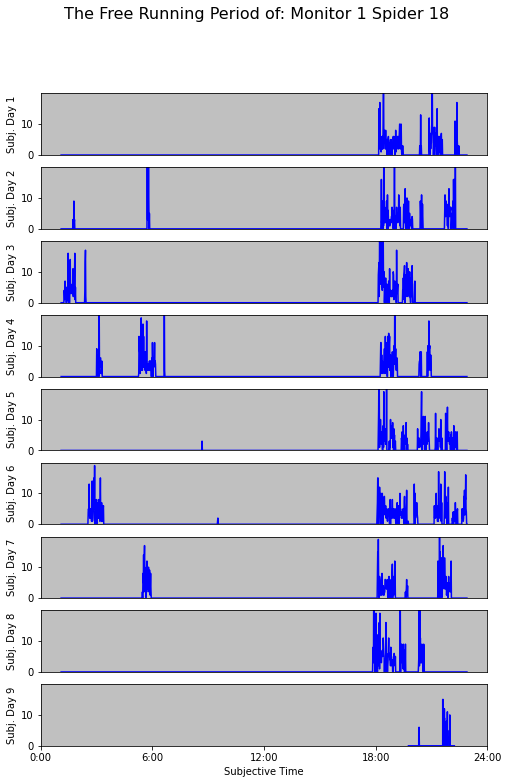

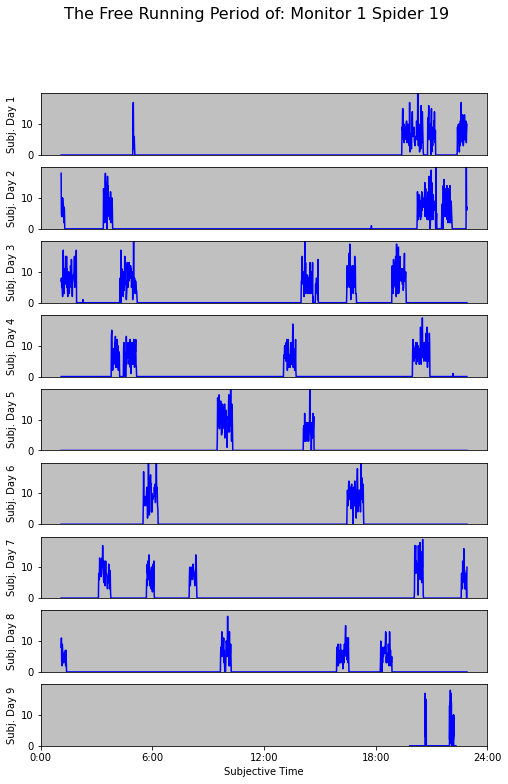

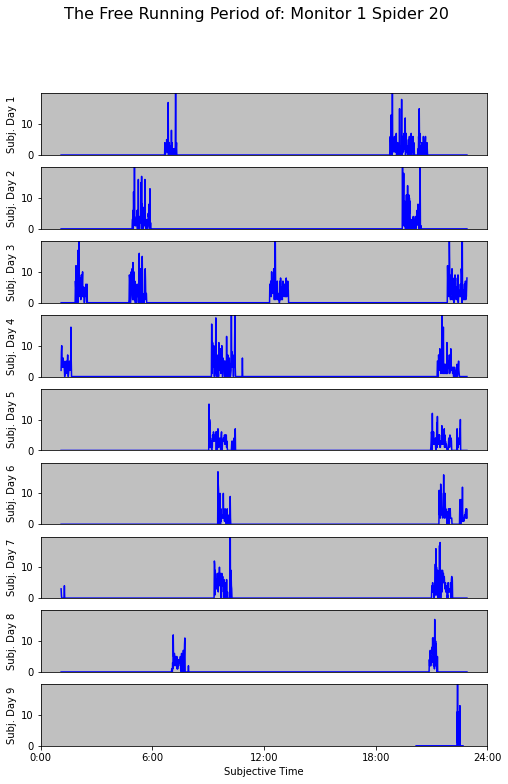

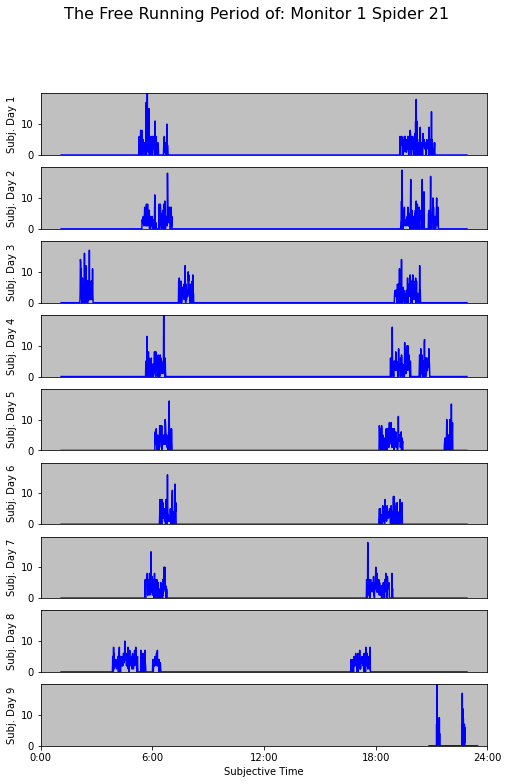

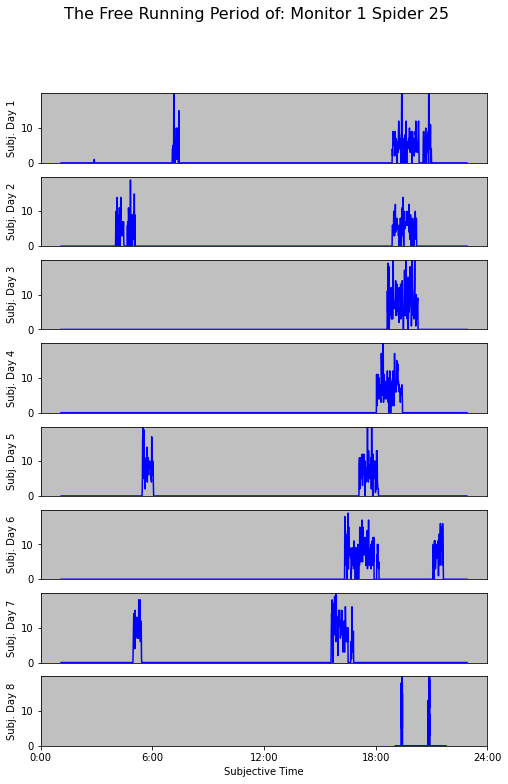

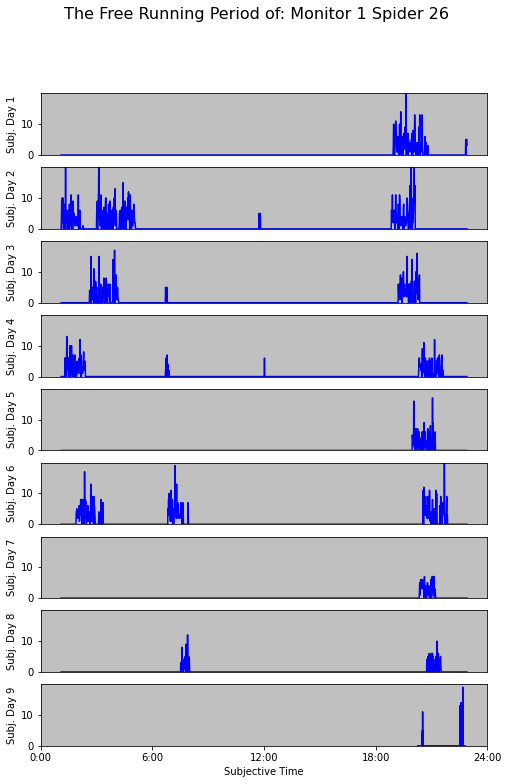

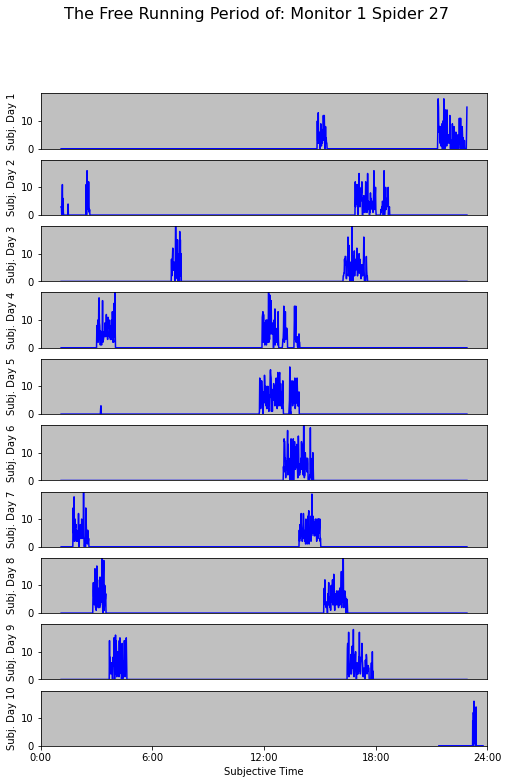

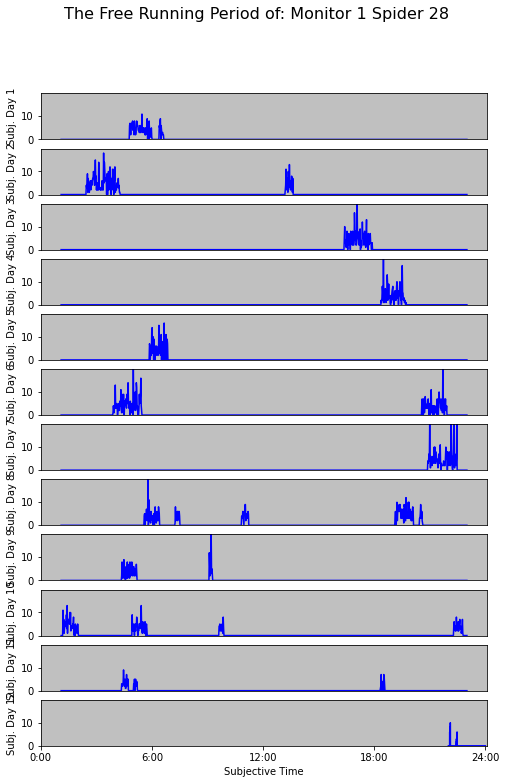

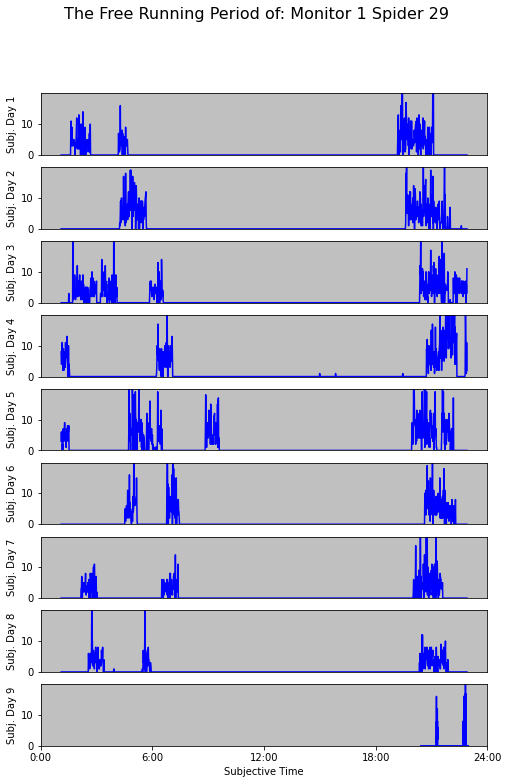

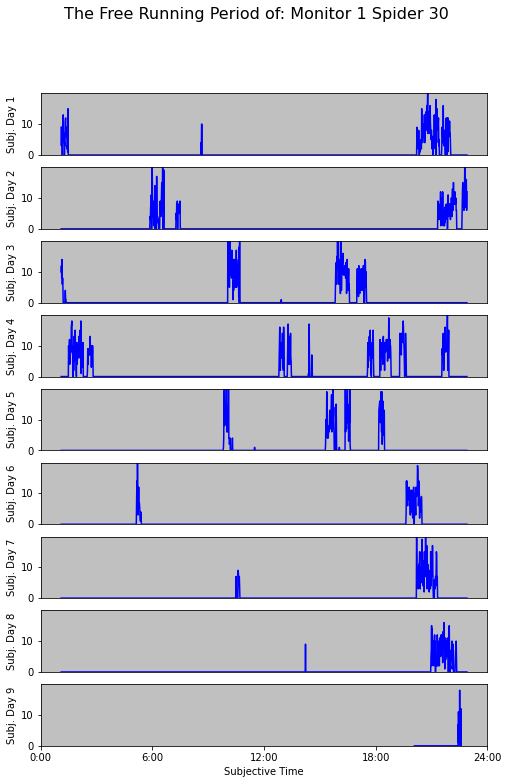

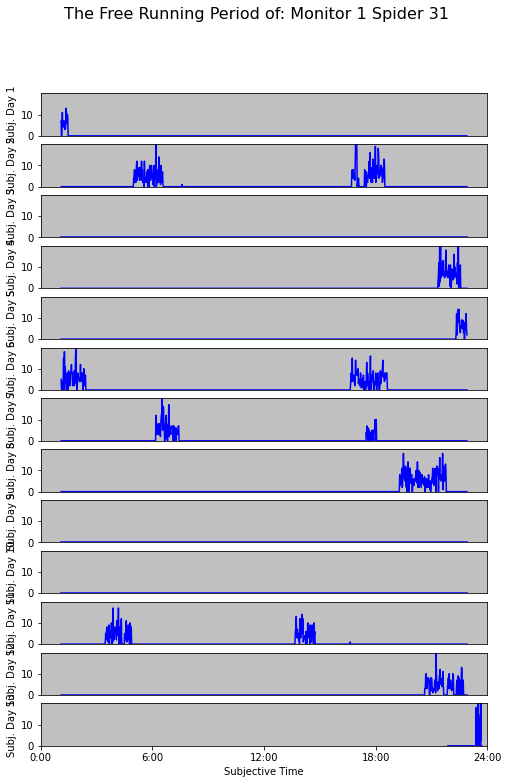

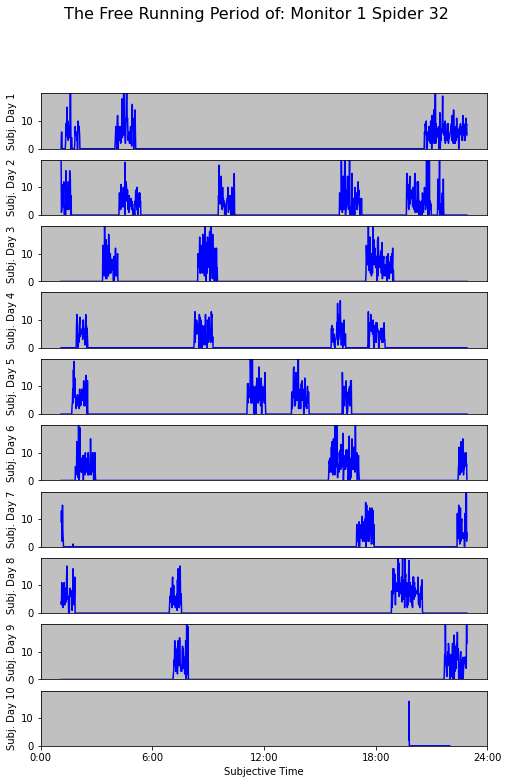

In [10]:
spider_raster(df,per)

In [11]:
#spider_raster(minusone, perone)

In [12]:
#spider_raster(minustwo,pertwo)

In [13]:

periods=pd.DataFrame()
periods['All Days']=per
periods['Minus Day 1']=perone
periods['Minus Day 1 and 2']=pertwo
display(periods)
periods.to_csv('Metazygia Period Data.csv')

All Days  Minus Day 1  Minus Day 1 and 2
Monitor 1 Spider 1   22.011150    22.101170          22.101074
Monitor 1 Spider 2   21.316001    21.411015          21.315825
Monitor 1 Spider 3   24.453386    24.159275          23.072459
Monitor 1 Spider 4   24.676897    24.592538          25.144622
Monitor 1 Spider 5   21.316001    21.949560          22.637170
Monitor 1 Spider 6   22.283665    22.101170          22.336171
Monitor 1 Spider 7   18.760847    18.846713          18.580817
Monitor 1 Spider 8   23.242881    23.280390          23.393771
Monitor 1 Spider 9   23.806503    23.799876          23.657338
Monitor 1 Spider 10  22.897901    23.393862          23.393771
Monitor 1 Spider 11  23.546960    23.978229          17.907361
Monitor 1 Spider 12  16.726750    14.692712          32.804848
Monitor 1 Spider 13  21.921787    21.315924          21.424570
Monitor 1 Spider 14  18.925236    18.519468          18.297470
Monitor 1 Spider 15  20.822787    20.762657          20.891666
Monitor 1 Spider 16  21.571475    21.949560          21.927975
Monitor 1 Spider 18  22.237778    22.152174          22.101074
Monitor 1 Spider 19  22.329742    14.006666          13.997811
Monitor 1 Spider 20  22.705329    22.410762          21.927975
Monitor 1 Spider 21  23.495729    23.508445          23.590891
Monitor 1 Spider 25  24.508883    24.655704          25.220124
Monitor 1 Spider 26  22.801209    22.622021          22.759853
Monitor 1 Spider 27  21.400484    21.800016          22.515802
Monitor 1 Spider 28  18.009941    18.809782          18.746704
Monitor 1 Spider 29  22.995418    22.837300          22.759853
Monitor 1 Spider 30  22.610253    22.891762          23.590891
Monitor 1 Spider 31  16.421527    16.540921          16.435622
Monitor 1 Spider 32  19.792376    20.584562          20.839830

# Experimenting with Different Periods

In [14]:
df=pd.read_csv('Metazygia monitor 1_DD.csv', index_col=0)
dfall=pd.read_csv('Metazygia monitor 1_DD_Stats.csv', index_col=0)
dfone=pd.read_csv('Metazygia monitor 1_DD-MINUS DAY 1_Stats.csv', index_col=0)
dftwo=pd.read_csv('Metazygia monitor 1_DD-MINUS DAY 1 AND 2_Stats.csv', index_col=0)
column=df.columns[1:]
perone=pd.DataFrame(data= dfone['Period'],index=column)
pertwo=pd.DataFrame(data= dftwo['Period'],index=column)
per=pd.DataFrame(data=dfall['Period'],index=column)
perT = per.T
dft = df.drop(columns = ['lights'])
columns=df.columns[1:]
dfnewper=df.loc[:,['lights','Monitor 1 Spider 6', 'Monitor 1 Spider 7', 'Monitor 1 Spider 11', 'Monitor 1 Spider 12', 'Monitor 1 Spider 15', 'Monitor 1 Spider 19', 'Monitor 1 Spider 25', 'Monitor 1 Spider 31']]
dfnewper.to_csv('Meta Test File.csv')

157.40711769562242


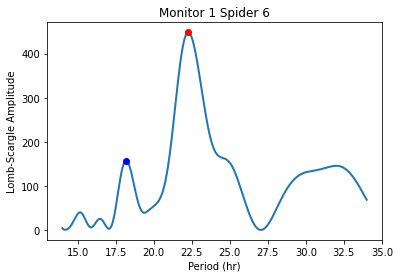

365.5098060055597


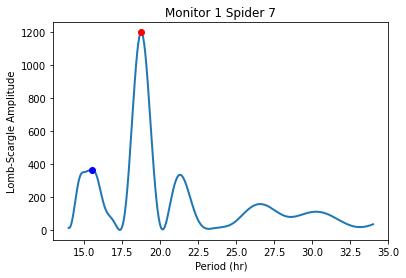

176.61786097308118


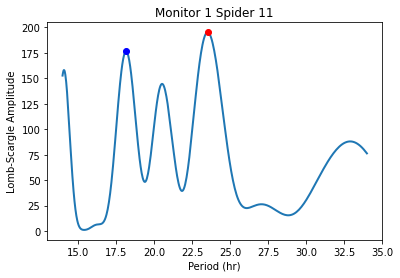

219.46031246304767


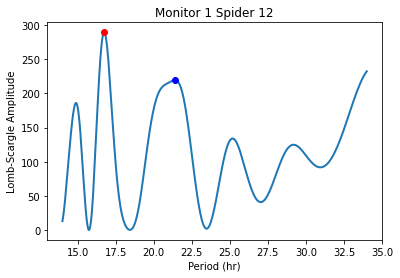

244.57903409294966


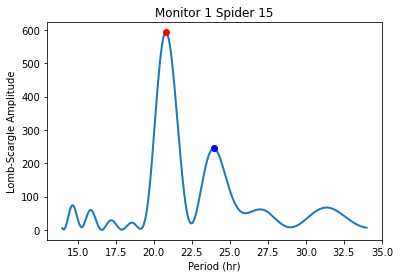

736.457940484809


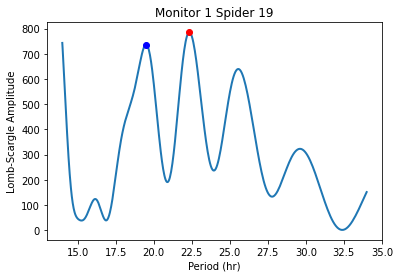

170.2458053324155


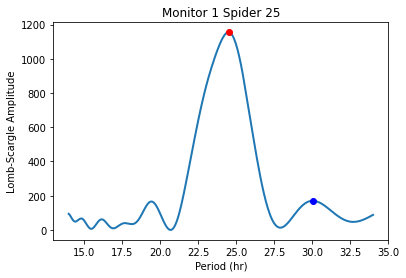

428.28183166545523


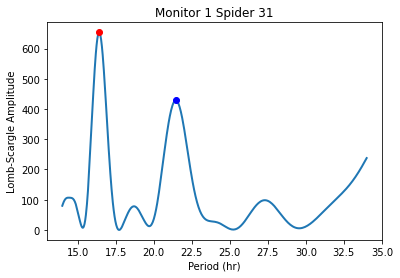

Period    Amplitude        p value
Spider                                                    
Monitor 1 Spider 6   22.283665   448.548039  1.108054e-189
Monitor 1 Spider 7   18.760847  1197.711121   0.000000e+00
Monitor 1 Spider 11  23.546960   195.296153   7.077836e-80
Monitor 1 Spider 12  16.726750   289.586299  9.677260e-121
Monitor 1 Spider 15  20.822787   592.966000  2.427996e-252
Monitor 1 Spider 19  22.329742   785.348799   0.000000e+00
Monitor 1 Spider 25  24.508883  1155.190593   0.000000e+00
Monitor 1 Spider 31  16.421527   653.895576  8.812693e-279

In [15]:
spider_datafile_base = "Meta Test File"       # specify the base filename for the set of spiders                       
df_out = LS_Period_Amplitude_FalseAlarm_Pgram(spider_datafile_base)
   # get the dataframe with Lomb-Scargle periodogram data, while outputting .png periodograms for each spider
df_outnew = df_out.set_index('Spider')     # reformat the index column in the dataframe
outfile = spider_datafile_base + '_Stats.csv'  # create the output filename for the dataframe with Lomb-Scargle stats
#df_out.to_csv(outfile)                # output the dataframe to file
display(df_outnew)                       # show the dataframe below

Monitor 1 Spider 6
Next spider
Monitor 1 Spider 7
Next spider
Monitor 1 Spider 11
Next spider
Monitor 1 Spider 12
Next spider
Monitor 1 Spider 15
Next spider
Monitor 1 Spider 19
Next spider
Monitor 1 Spider 25
Next spider
Monitor 1 Spider 31
Next spider


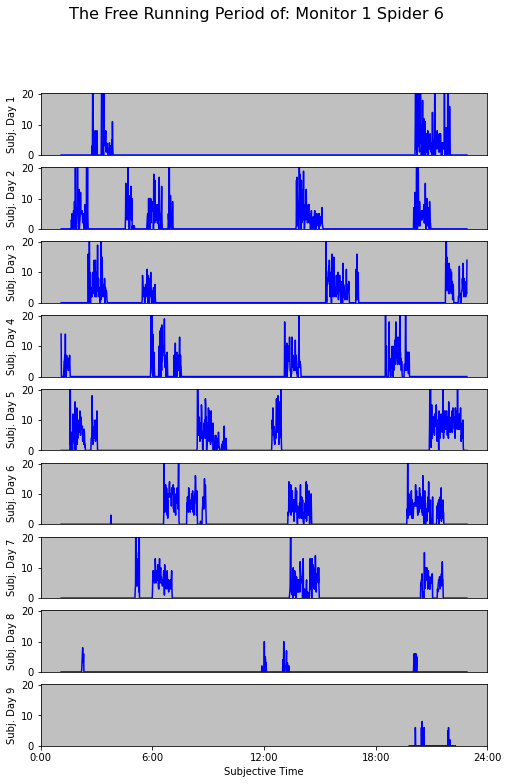

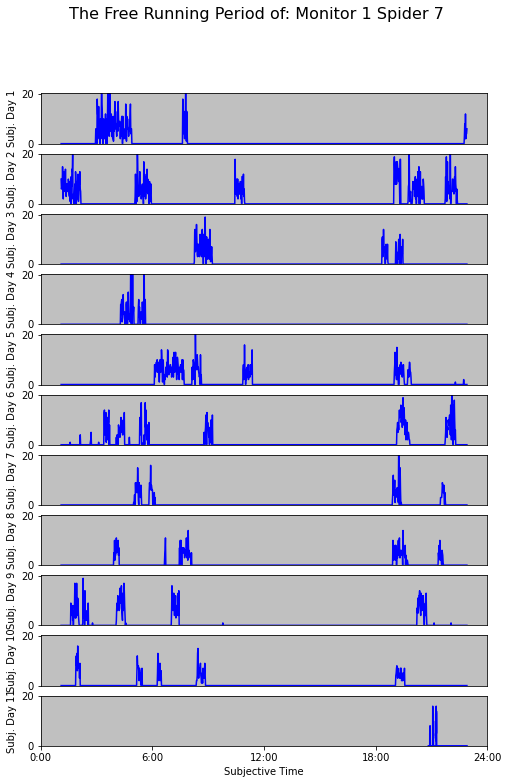

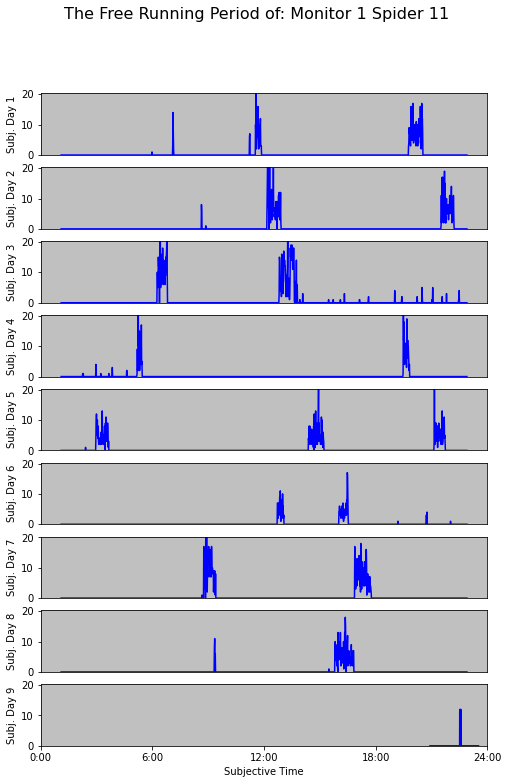

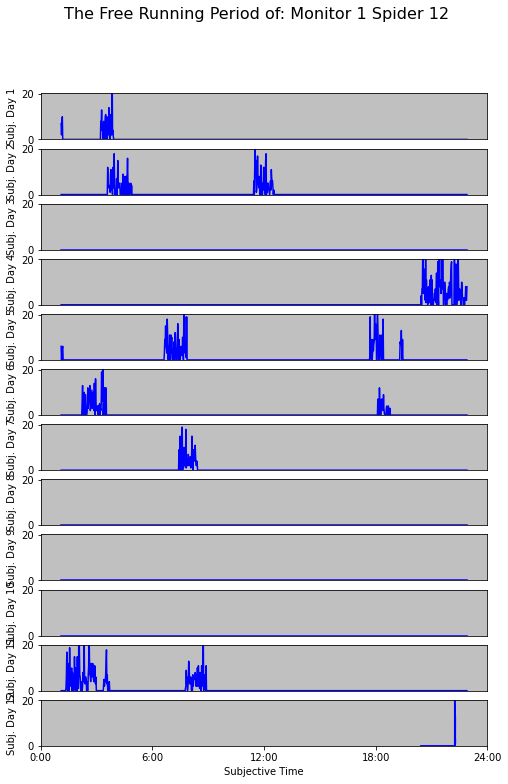

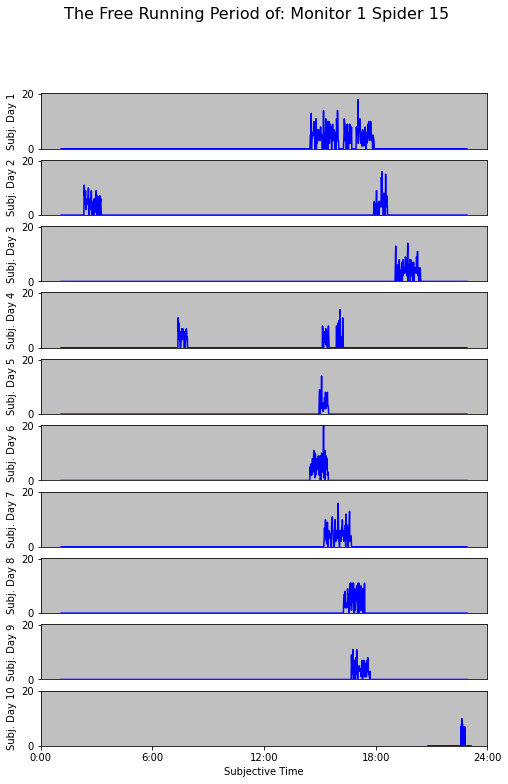

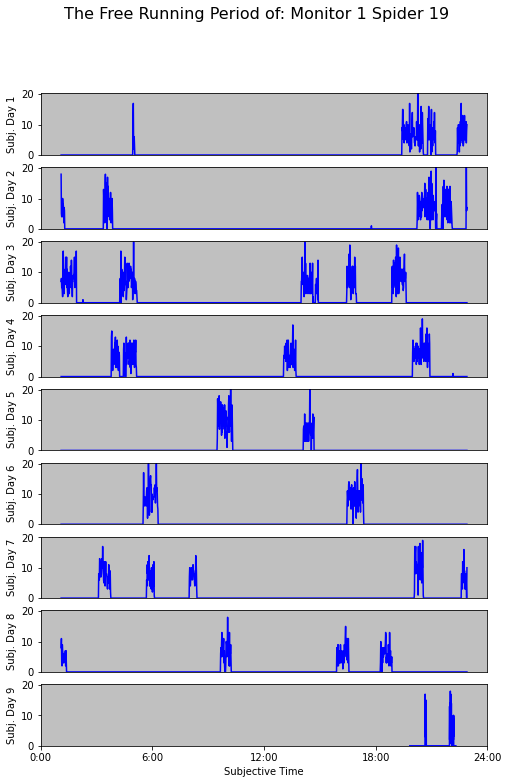

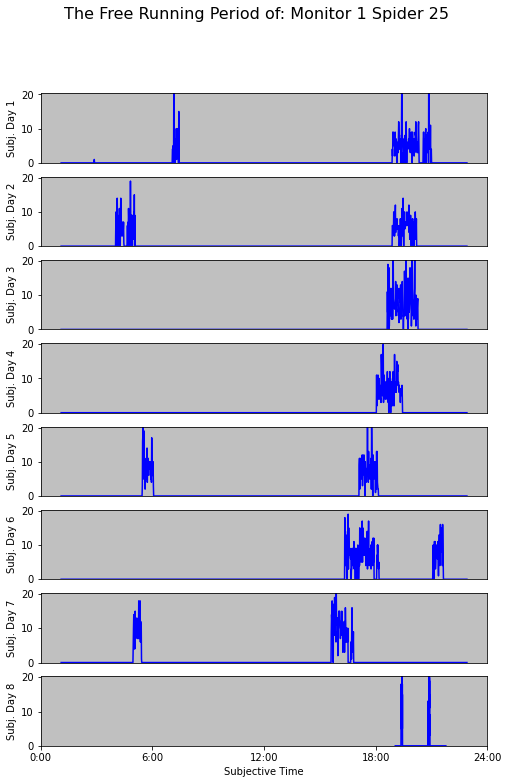

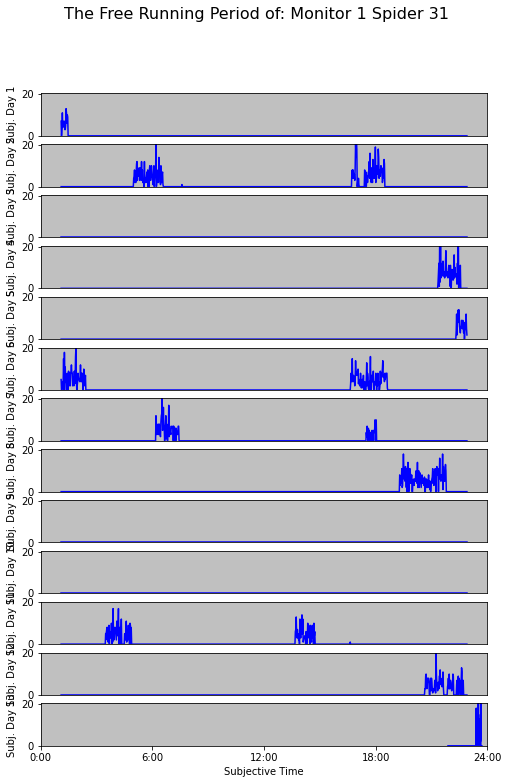

In [16]:
pertest=pd.DataFrame(data= df_outnew['Period'],index=dfnewper.columns[1:])
spider_raster(dfnewper,pertest)

In [17]:
day=60*24
minusone=pd.read_csv('Metazygia monitor 1_DD-MINUS DAY 1.csv',index_col=0)
minustwo=pd.read_csv('Metazygia monitor 1_DD-MINUS DAY 1 AND 2.csv', index_col=0)
testminusone=minusone.loc[:,['lights','Monitor 1 Spider 19']]
testminusone.to_csv('TEST DELETE 1.csv')
testminustwo=minustwo.loc[:,['lights','Monitor 1 Spider 19']]
testminustwo.to_csv('TEST DELETE 2.csv')

610.3237481958519


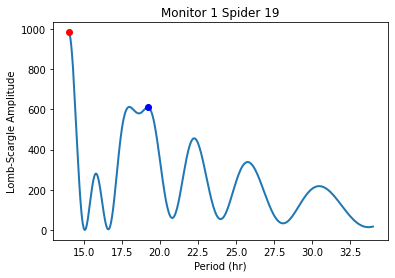

Period   Amplitude  p value
Spider                                             
Monitor 1 Spider 19  14.006666  984.205956      0.0

In [18]:
spider_datafile_base = "TEST DELETE 1"       # specify the base filename for the set of spiders                       
df_outonetest = LS_Period_Amplitude_FalseAlarm_Pgram(spider_datafile_base)
   # get the dataframe with Lomb-Scargle periodogram data, while outputting .png periodograms for each spider
df_outonetest = df_outonetest.set_index('Spider')     # reformat the index column in the dataframe
outfile = spider_datafile_base + '_Stats.csv'  # create the output filename for the dataframe with Lomb-Scargle stats
#df_out.to_csv(outfile)                # output the dataframe to file
display(df_outonetest.head())                       # show the dataframe below
peronetest=pd.DataFrame(data= df_outonetest['Period'],index=testminusone.columns[1:])


210.74072459782482


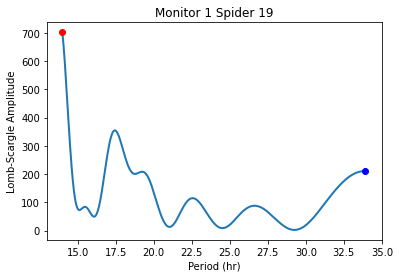

Period   Amplitude        p value
Spider                                                   
Monitor 1 Spider 19  13.997811  702.282676  6.874195e-300

In [19]:
spider_datafile_base = "TEST DELETE 2"       # specify the base filename for the set of spiders                       
df_outtwotest = LS_Period_Amplitude_FalseAlarm_Pgram(spider_datafile_base)
   # get the dataframe with Lomb-Scargle periodogram data, while outputting .png periodograms for each spider
df_outtwotest = df_outtwotest.set_index('Spider')     # reformat the index column in the dataframe
outfile = spider_datafile_base + '_Stats.csv'  # create the output filename for the dataframe with Lomb-Scargle stats
#df_out.to_csv(outfile)                # output the dataframe to file
display(df_outtwotest.head())                       # show the dataframe below
pertwotest=pd.DataFrame(data= df_outtwotest['Period'],index=testminustwo.columns[1:])


Monitor 1 Spider 19
Next spider


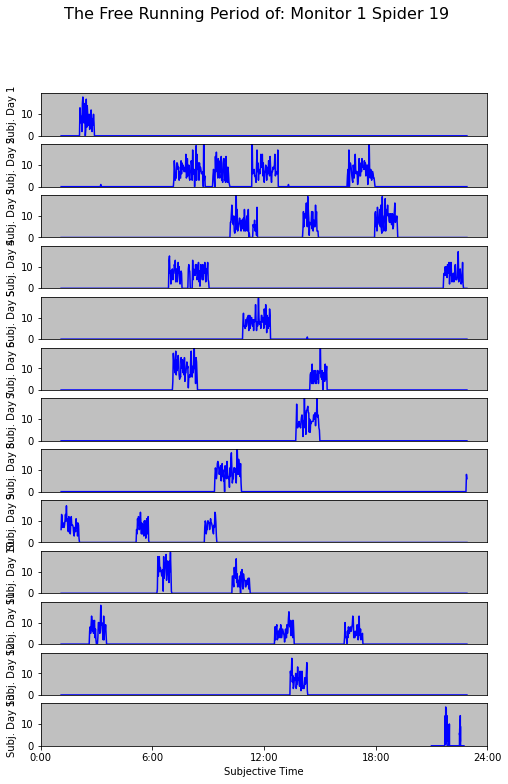

In [20]:
spider_raster(testminusone, peronetest)

Monitor 1 Spider 19
Next spider


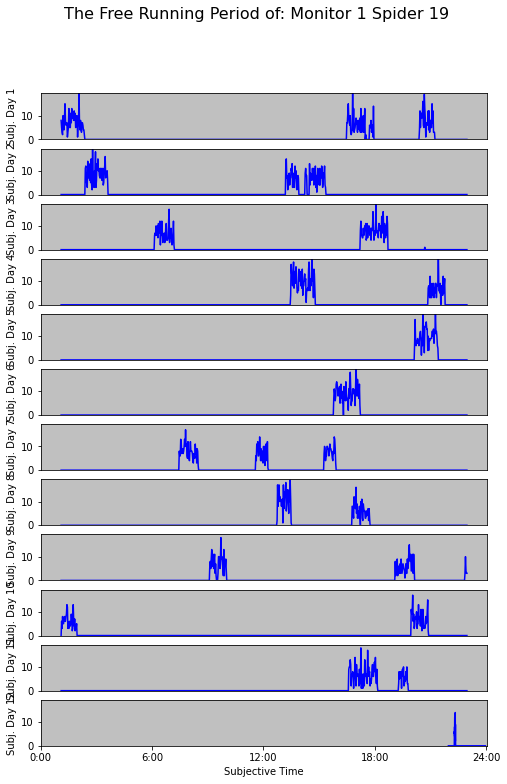

In [21]:
spider_raster(testminustwo, pertwotest)

# Add/Subtract 10-15 Minutes

All Days
Monitor 1 Spider 1   21.841150
Monitor 1 Spider 2   21.146001
Monitor 1 Spider 3   24.283386
Monitor 1 Spider 4   24.506897
Monitor 1 Spider 5   21.146001
Monitor 1 Spider 6   22.113665
Monitor 1 Spider 7   18.590847
Monitor 1 Spider 8   23.072881
Monitor 1 Spider 9   23.636503
Monitor 1 Spider 10  22.727901
Monitor 1 Spider 11  23.376960
Monitor 1 Spider 12  16.556750
Monitor 1 Spider 13  21.751787
Monitor 1 Spider 14  18.755236
Monitor 1 Spider 15  20.652787
Monitor 1 Spider 16  21.401475
Monitor 1 Spider 18  22.067778
Monitor 1 Spider 19  22.159742
Monitor 1 Spider 20  22.535329
Monitor 1 Spider 21  23.325729
Monitor 1 Spider 25  24.338883
Monitor 1 Spider 26  22.631209
Monitor 1 Spider 27  21.230484
Monitor 1 Spider 28  17.839941
Monitor 1 Spider 29  22.825418
Monitor 1 Spider 30  22.440253
Monitor 1 Spider 31  16.251527
Monitor 1 Spider 32  19.622376

Monitor 1 Spider 32
Next spider


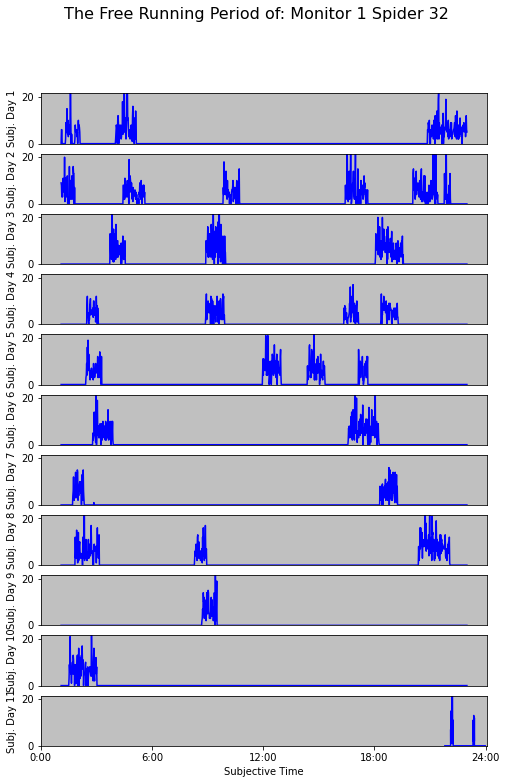

In [22]:
df=pd.read_csv('Metazygia monitor 1_DD.csv',index_col=0)
manual=df.loc[:,['lights',  'Monitor 1 Spider 32']]
per=pd.read_csv('Metazygia Period Data.csv', index_col=0)
perall=per.loc[:,['All Days']]
perall['All Days']=perall['All Days']-.17 #Add 15 min
display(perall)
#spider_raster(manual, perall)
spider_raster(manual,perall)

# Binary Period

In [23]:
dfc=df.copy()
column=dfc.columns[1:]
for spider in range(len(column)):
    dfc[column[spider]] = dfc[column[spider]].apply(lambda x: 1 if x != 0 else 0)
    
display(dfc.head())

lights  Monitor 1 Spider 1  Monitor 1 Spider 2  \
Date_Time                                                             
2017-04-26 00:00:00       0                   0                   0   
2017-04-26 00:01:00       0                   1                   0   
2017-04-26 00:02:00       0                   1                   0   
2017-04-26 00:03:00       0                   1                   0   
2017-04-26 00:04:00       0                   1                   0   

                     Monitor 1 Spider 3  Monitor 1 Spider 4  \
Date_Time                                                     
2017-04-26 00:00:00                   0                   0   
2017-04-26 00:01:00                   0                   0   
2017-04-26 00:02:00                   0                   0   
2017-04-26 00:03:00                   0                   0   
2017-04-26 00:04:00                   0                   0   

                     Monitor 1 Spider 5  Monitor 1 Spider 6  \
Date_Time                                                     
2017-04-26 00:00:00                   0                   0   
2017-04-26 00:01:00                   0                   0   
2017-04-26 00:02:00                   0                   0   
2017-04-26 00:03:00                   0                   0   
2017-04-26 00:04:00                   0                   0   

                     Monitor 1 Spider 7  Monitor 1 Spider 8  \
Date_Time                                                     
2017-04-26 00:00:00                   0                   0   
2017-04-26 00:01:00                   0                   0   
2017-04-26 00:02:00                   0                   0   
2017-04-26 00:03:00                   0                   0   
2017-04-26 00:04:00                   0                   0   

                     Monitor 1 Spider 9  ...  Monitor 1 Spider 20  \
Date_Time                                ...                        
2017-04-26 00:00:00                   0  ...                    0   
2017-04-26 00:01:00                   0  ...                    0   
2017-04-26 00:02:00                   0  ...                    0   
2017-04-26 00:03:00                   0  ...                    0   
2017-04-26 00:04:00                   0  ...                    0   

                     Monitor 1 Spider 21  Monitor 1 Spider 25  \
Date_Time                                                       
2017-04-26 00:00:00                    0                    0   
2017-04-26 00:01:00                    0                    0   
2017-04-26 00:02:00                    0                    0   
2017-04-26 00:03:00                    0                    0   
2017-04-26 00:04:00                    0                    0   

                     Monitor 1 Spider 26  Monitor 1 Spider 27  \
Date_Time                                                       
2017-04-26 00:00:00                    0                    0   
2017-04-26 00:01:00                    0                    0   
2017-04-26 00:02:00                    0                    0   
2017-04-26 00:03:00                    0                    0   
2017-04-26 00:04:00                    0                    0   

                     Monitor 1 Spider 28  Monitor 1 Spider 29  \
Date_Time                                                       
2017-04-26 00:00:00                    0                    0   
2017-04-26 00:01:00                    0                    0   
2017-04-26 00:02:00                    0                    0   
2017-04-26 00:03:00                    0                    0   
2017-04-26 00:04:00                    0                    0   

                     Monitor 1 Spider 30  Monitor 1 Spider 31  \
Date_Time                                                       
2017-04-26 00:00:00                    1                    1   
2017-04-26 00:01:00                    1                    0   
2017-04-26 00:02:00                    1                    1   
2017-04-26 00:03:00 

In [24]:
dfc.to_csv("Binary DF_DD.csv")

2.341847061584394


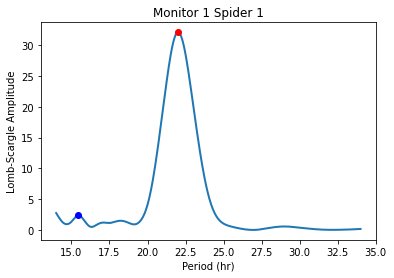

5.9593406418132595


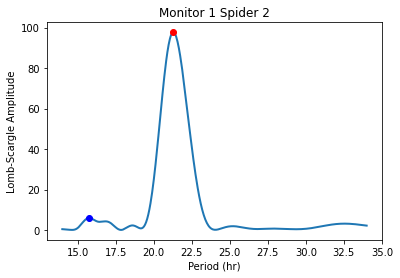

18.869256516572044


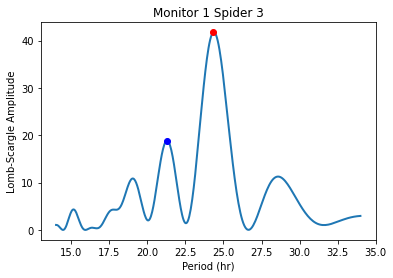

16.871830315249333


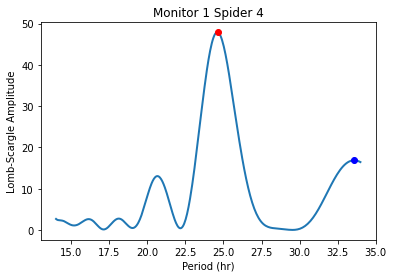

15.099324851473957


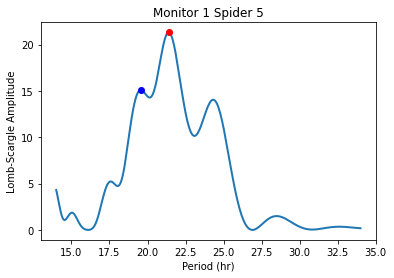

4.013833699813097


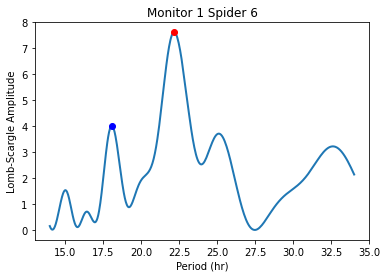

6.937137535467914


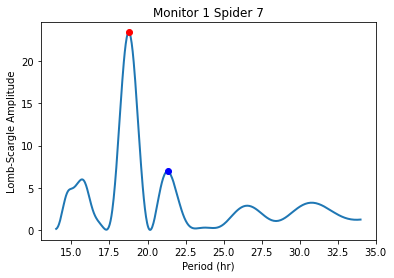

3.200493946541945


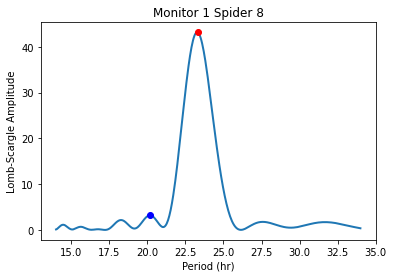

6.135779086188923


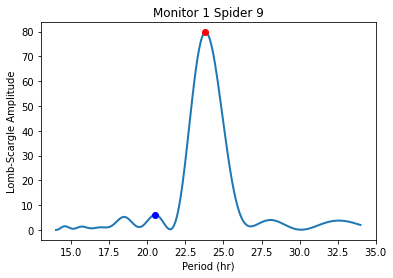

8.279507586391388


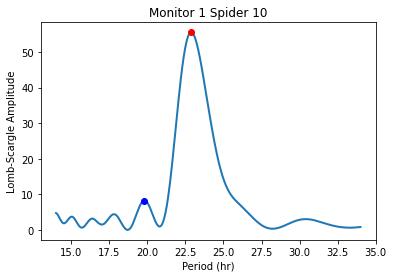

3.069663659275065


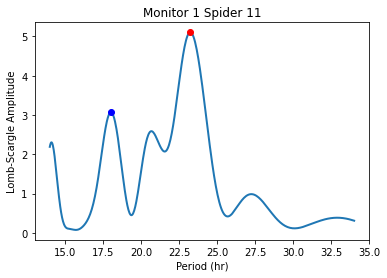

4.608087204287502


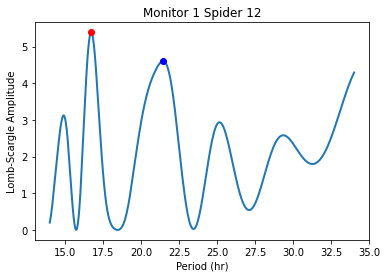

7.951248729395586


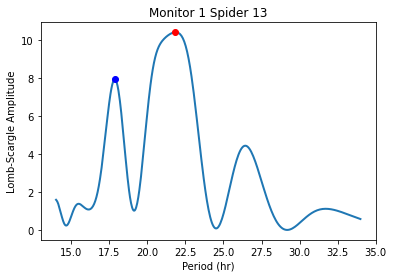

3.561612975711777


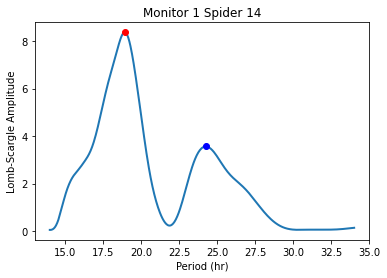

9.587110085923207


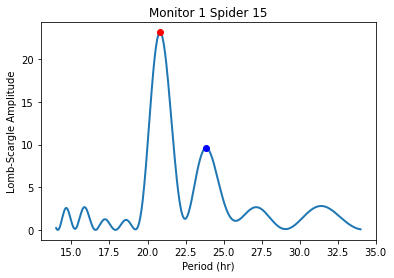

5.709778632359751


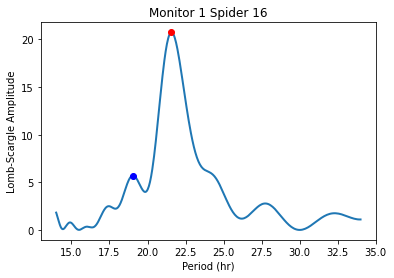

11.33281170457628


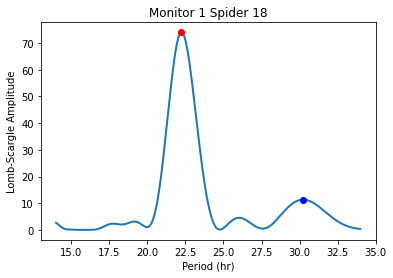

12.434308171129132


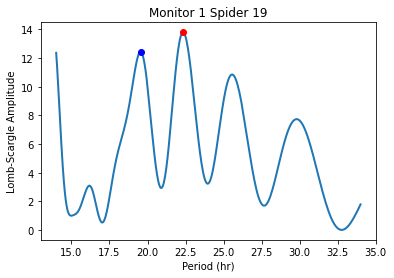

1.9254401247433361


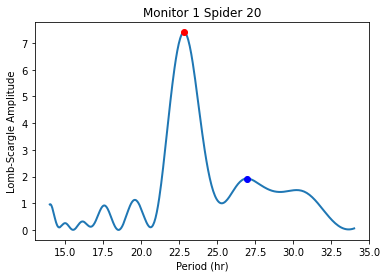

3.73593233489736


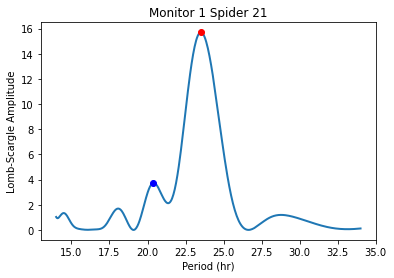

2.647130427414847


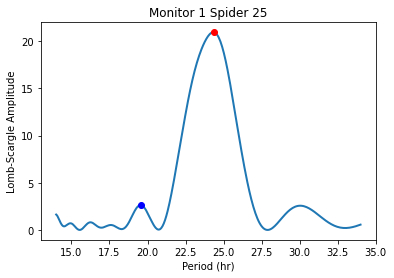

5.227018109793642


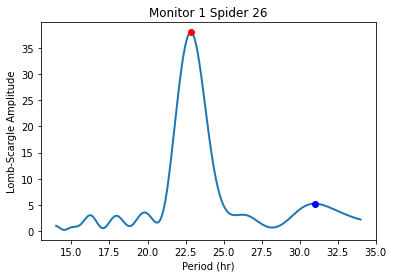

9.717636930490912


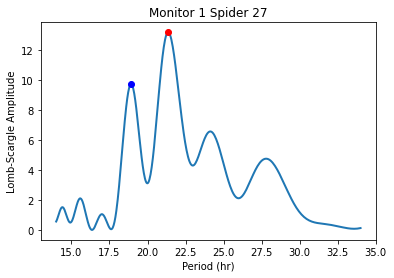

8.764345877644159


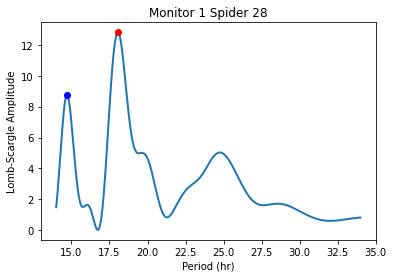

6.307581422460141


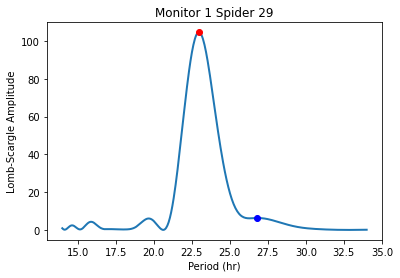

7.8385431089061814


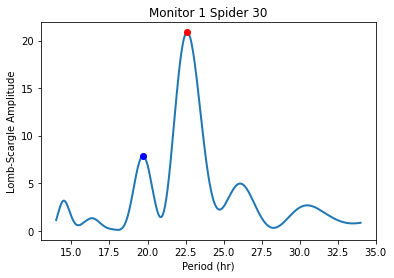

9.856217914352932


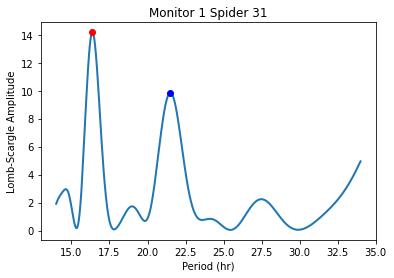

15.379274329666663


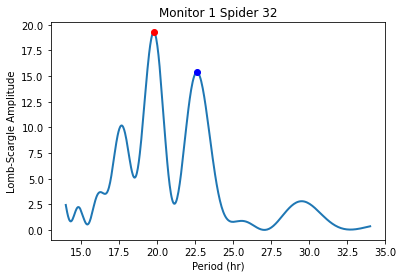

Period  Amplitude       p value
Spider                                                
Monitor 1 Spider 1  22.011150  32.097696  2.157651e-09
Monitor 1 Spider 2  21.274009  97.699565  1.216633e-37
Monitor 1 Spider 3  24.343142  41.760018  1.566141e-13
Monitor 1 Spider 4  24.620637  47.907393  3.588234e-16
Monitor 1 Spider 5  21.400484  21.322867  8.406165e-05

In [25]:
spider_datafile_base = "Binary DF_DD"                    
df_outbinary = LS_Period_Amplitude_FalseAlarm_Pgram(spider_datafile_base)
df_outbinary = df_outbinary.set_index('Spider')   
#outfile = spider_datafile_base + '_Stats.csv'  
#df_out.to_csv(outfile)              
display(df_outbinary.head())                     

In [26]:
period=pd.read_csv('Metazygia Period Data.csv', index_col=0)
period['Binary Period']=df_outbinary['Period']
display(period)
period.to_csv('Metazygia Period Data.csv')

All Days  Minus Day 1  Minus Day 1 and 2  Binary Period
Monitor 1 Spider 1   22.011150    22.101170          22.101074      22.011150
Monitor 1 Spider 2   21.316001    21.411015          21.315825      21.274009
Monitor 1 Spider 3   24.453386    24.159275          23.072459      24.343142
Monitor 1 Spider 4   24.676897    24.592538          25.144622      24.620637
Monitor 1 Spider 5   21.316001    21.949560          22.637170      21.400484
Monitor 1 Spider 6   22.283665    22.101170          22.336171      22.146569
Monitor 1 Spider 7   18.760847    18.846713          18.580817      18.760847
Monitor 1 Spider 8   23.242881    23.280390          23.393771      23.293014
Monitor 1 Spider 9   23.806503    23.799876          23.657338      23.806503
Monitor 1 Spider 10  22.897901    23.393862          23.393771      22.897901
Monitor 1 Spider 11  23.546960    23.978229          17.907361      23.242881
Monitor 1 Spider 12  16.726750    14.692712          32.804848      16.726750
Monitor 1 Spider 13  21.921787    21.315924          21.424570      21.833147
Monitor 1 Spider 14  18.925236    18.519468          18.297470      18.925236
Monitor 1 Spider 15  20.822787    20.762657          20.891666      20.822787
Monitor 1 Spider 16  21.571475    21.949560          21.927975      21.571475
Monitor 1 Spider 18  22.237778    22.152174          22.101074      22.237778
Monitor 1 Spider 19  22.329742    14.006666          13.997811      22.329742
Monitor 1 Spider 20  22.705329    22.410762          21.927975      22.801209
Monitor 1 Spider 21  23.495729    23.508445          23.590891      23.495729
Monitor 1 Spider 25  24.508883    24.655704          25.220124      24.343142
Monitor 1 Spider 26  22.801209    22.622021          22.759853      22.849453
Monitor 1 Spider 27  21.400484    21.800016          22.515802      21.358159
Monitor 1 Spider 28  18.009941    18.809782          18.746704      18.040027
Monitor 1 Spider 29  22.995418    22.837300          22.759853      22.995418
Monitor 1 Spider 30  22.610253    22.891762          23.590891      22.610253
Monitor 1 Spider 31  16.421527    16.540921          16.435622      16.371737
Monitor 1 Spider 32  19.792376    20.584562          20.839830      19.792376

In [27]:
perbinary=period.loc[:,['Binary Period']]
display(perbinary)

Binary Period
Monitor 1 Spider 1       22.011150
Monitor 1 Spider 2       21.274009
Monitor 1 Spider 3       24.343142
Monitor 1 Spider 4       24.620637
Monitor 1 Spider 5       21.400484
Monitor 1 Spider 6       22.146569
Monitor 1 Spider 7       18.760847
Monitor 1 Spider 8       23.293014
Monitor 1 Spider 9       23.806503
Monitor 1 Spider 10      22.897901
Monitor 1 Spider 11      23.242881
Monitor 1 Spider 12      16.726750
Monitor 1 Spider 13      21.833147
Monitor 1 Spider 14      18.925236
Monitor 1 Spider 15      20.822787
Monitor 1 Spider 16      21.571475
Monitor 1 Spider 18      22.237778
Monitor 1 Spider 19      22.329742
Monitor 1 Spider 20      22.801209
Monitor 1 Spider 21      23.495729
Monitor 1 Spider 25      24.343142
Monitor 1 Spider 26      22.849453
Monitor 1 Spider 27      21.358159
Monitor 1 Spider 28      18.040027
Monitor 1 Spider 29      22.995418
Monitor 1 Spider 30      22.610253
Monitor 1 Spider 31      16.371737
Monitor 1 Spider 32      19.792376

Monitor 1 Spider 1
Next spider
Monitor 1 Spider 2
Next spider
Monitor 1 Spider 3
Next spider
Monitor 1 Spider 4
Next spider
Monitor 1 Spider 5
Next spider
Monitor 1 Spider 6
Next spider
Monitor 1 Spider 7
Next spider
Monitor 1 Spider 8
Next spider
Monitor 1 Spider 9
Next spider
Monitor 1 Spider 10
Next spider
Monitor 1 Spider 11
Next spider
Monitor 1 Spider 12
Next spider
Monitor 1 Spider 13
Next spider
Monitor 1 Spider 14
Next spider
Monitor 1 Spider 15
Next spider
Monitor 1 Spider 16
Next spider
Monitor 1 Spider 18
Next spider
Monitor 1 Spider 19
Next spider
Monitor 1 Spider 20
Next spider
Monitor 1 Spider 21
Next spider
Monitor 1 Spider 25


<ipython-input-8-4dc8525d025d>:79: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax=plt.subplots(num_days,1, figsize=(8,12), sharey=True)


Next spider
Monitor 1 Spider 26
Next spider
Monitor 1 Spider 27
Next spider
Monitor 1 Spider 28
Next spider
Monitor 1 Spider 29
Next spider
Monitor 1 Spider 30
Next spider
Monitor 1 Spider 31
Next spider
Monitor 1 Spider 32
Next spider


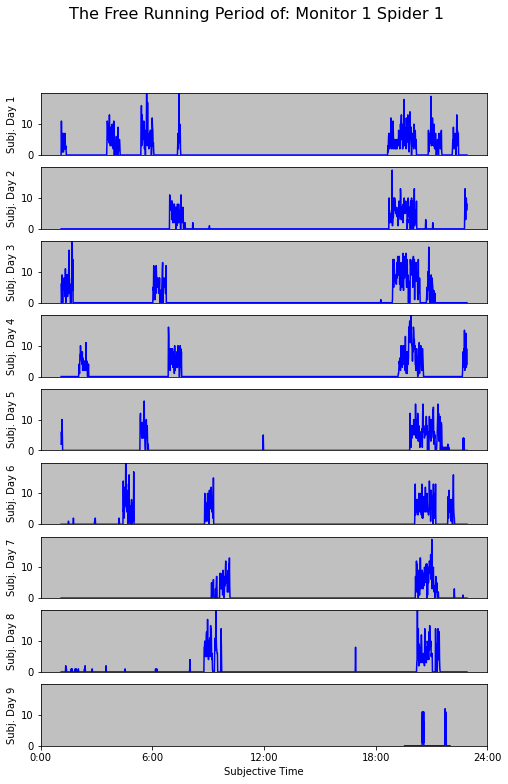

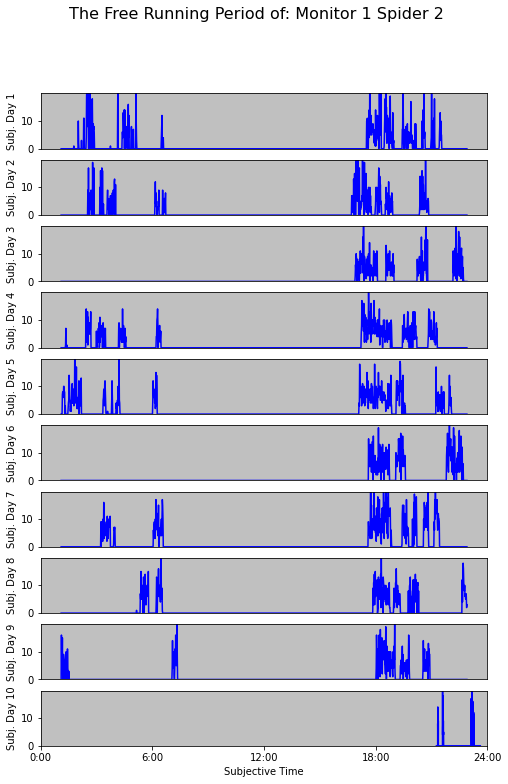

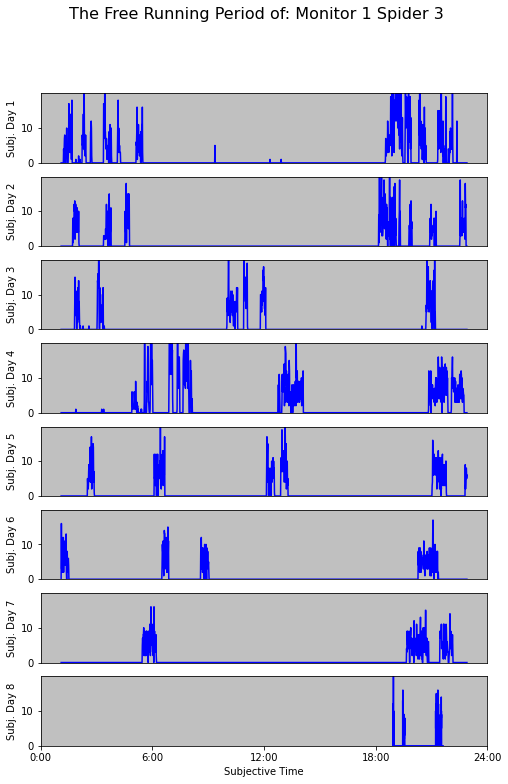

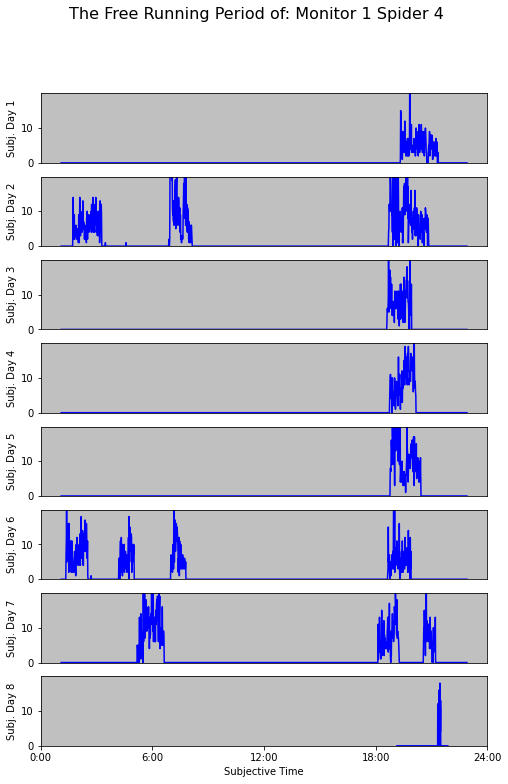

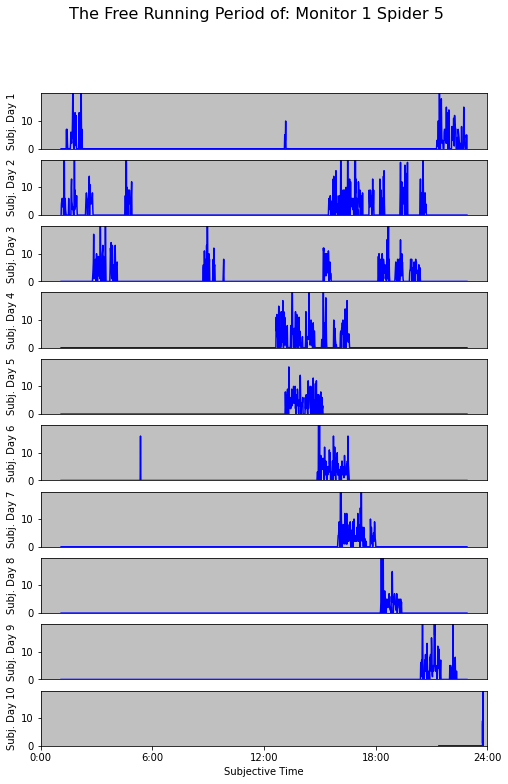

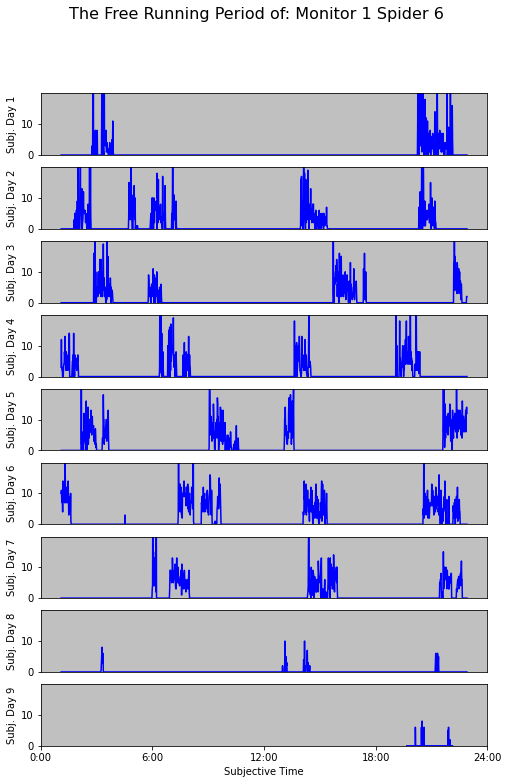

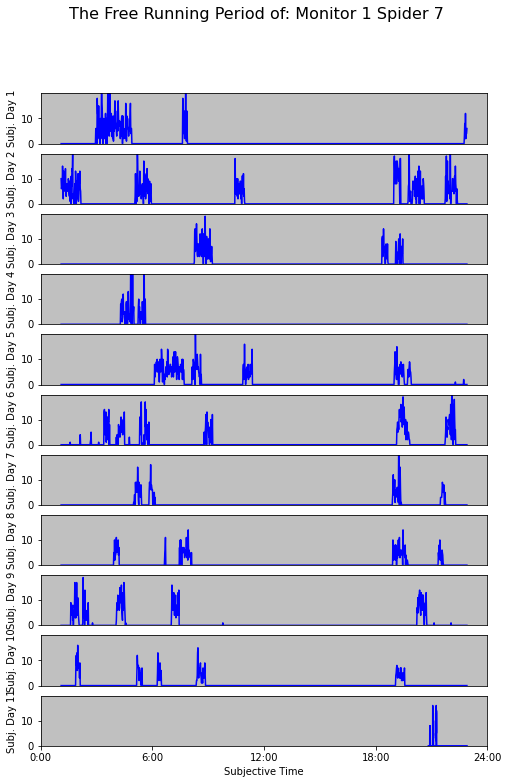

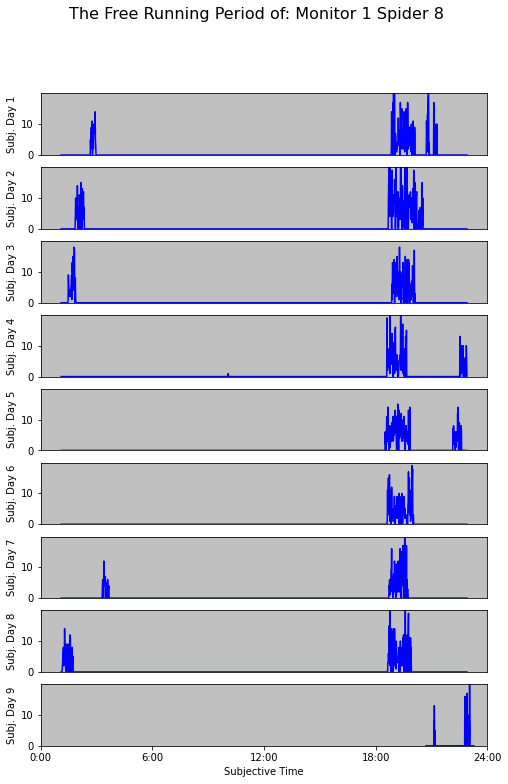

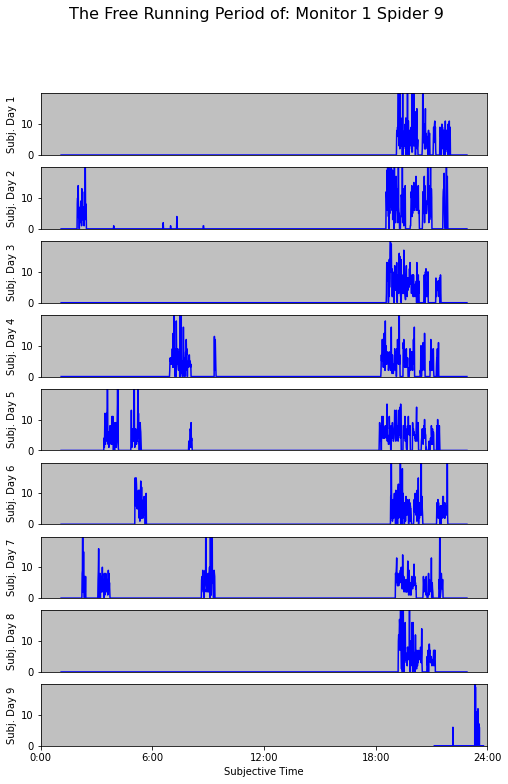

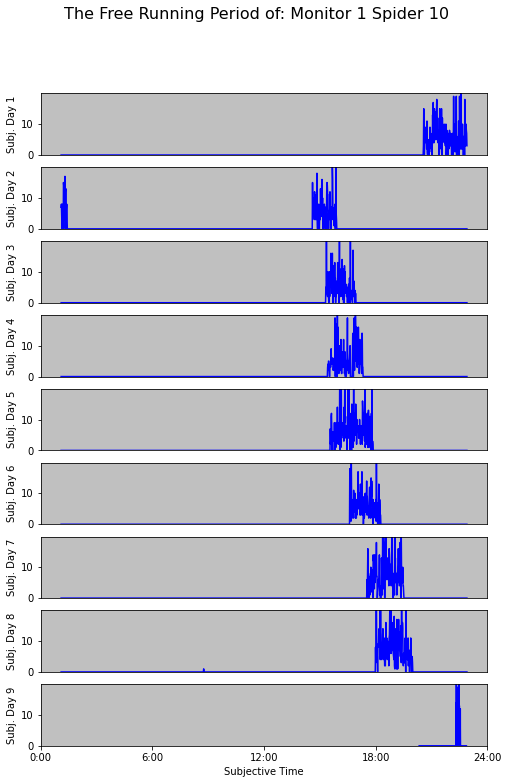

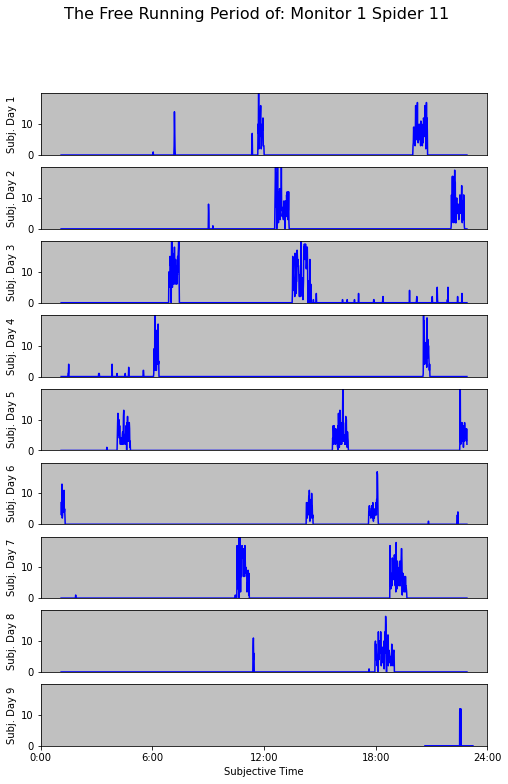

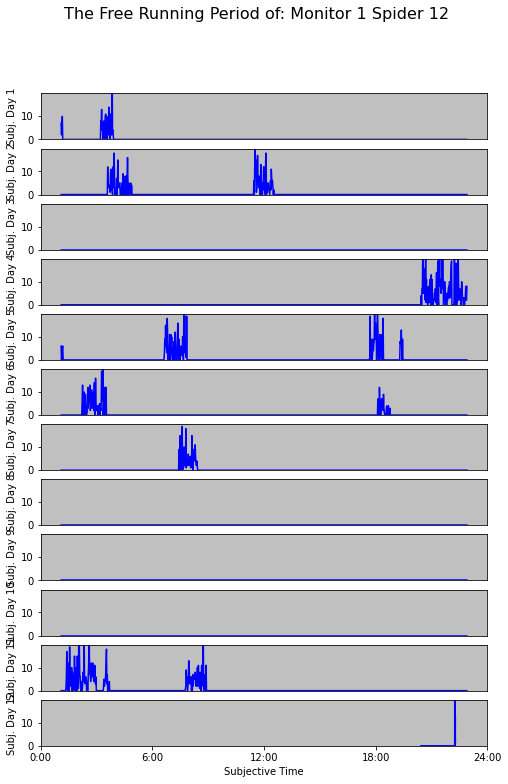

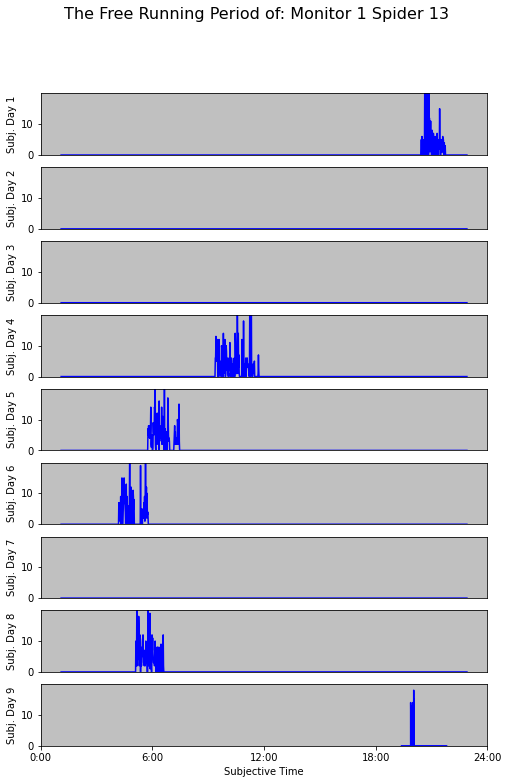

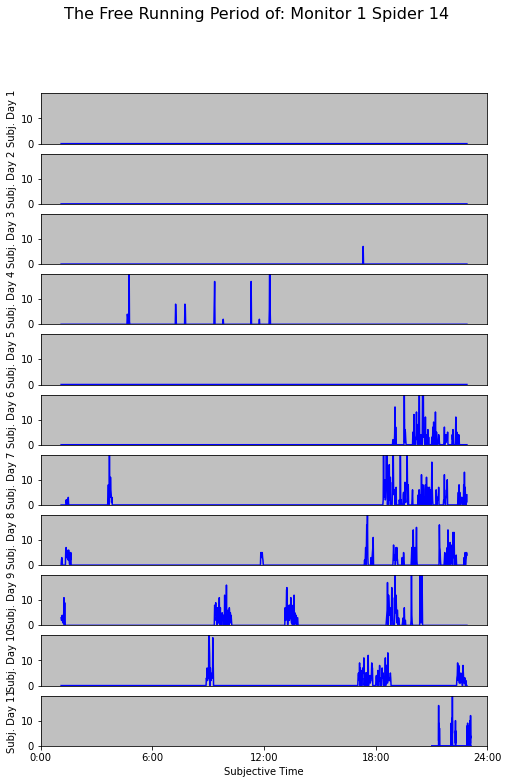

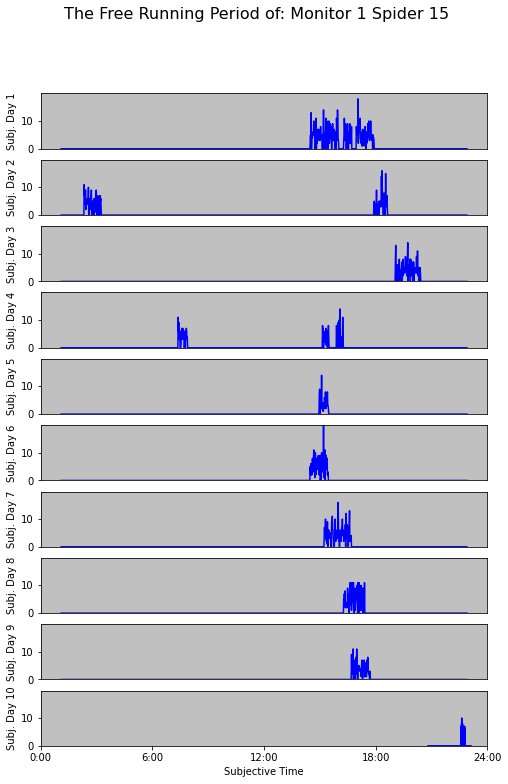

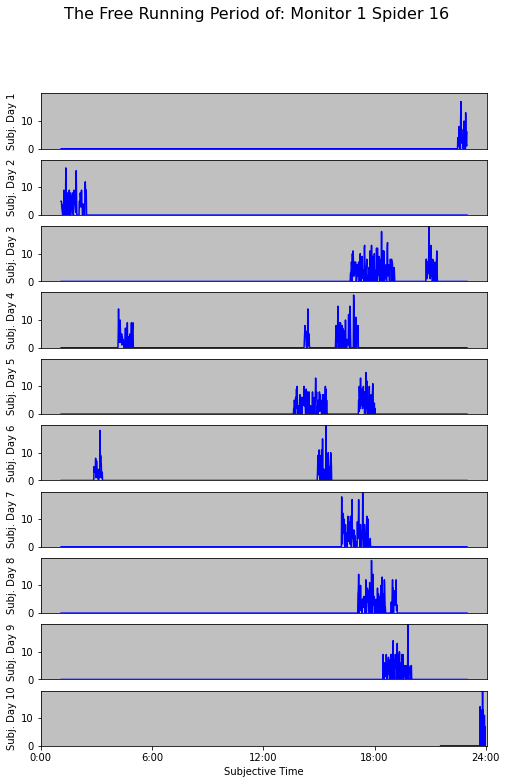

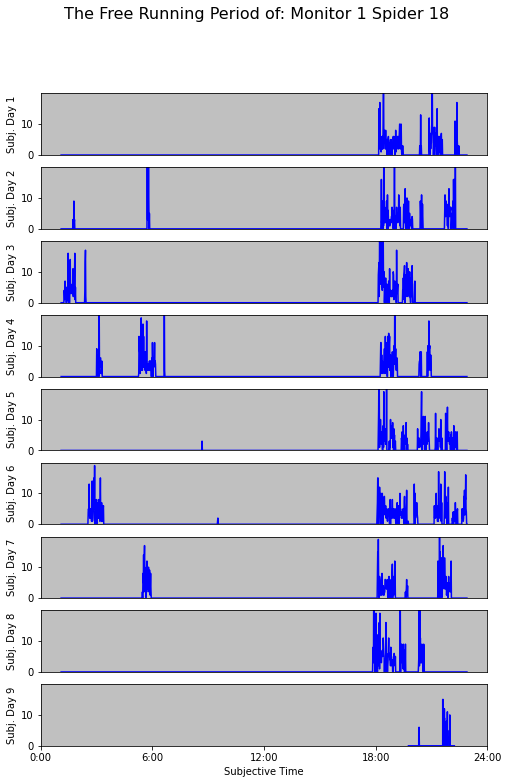

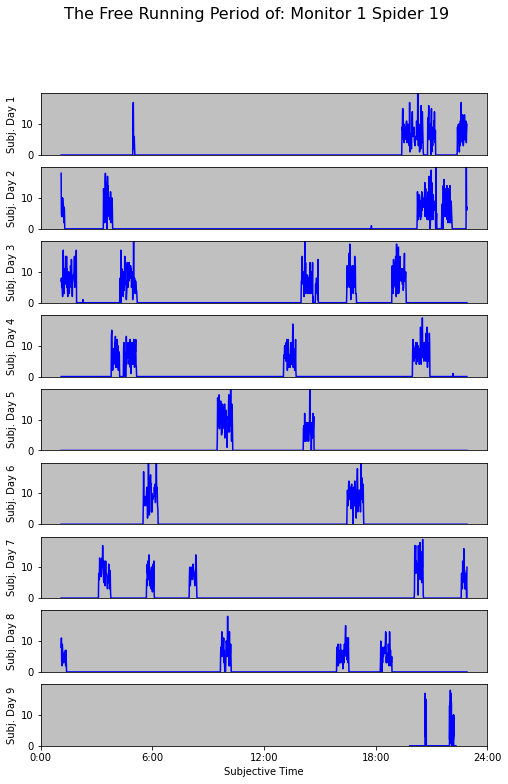

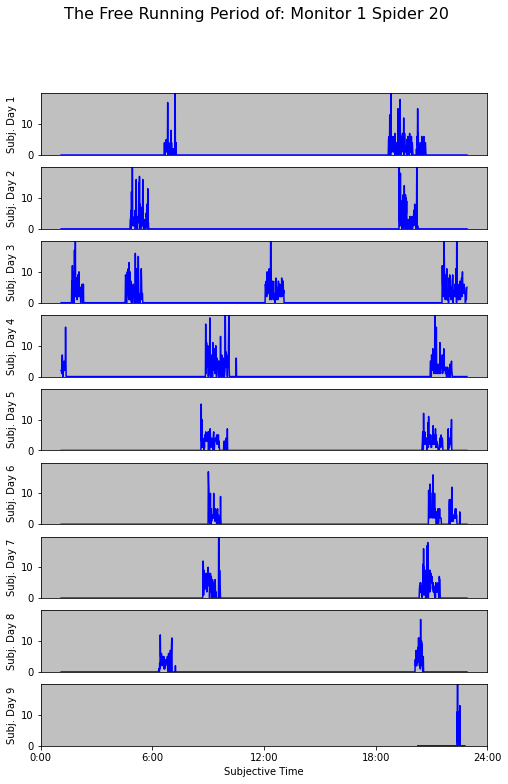

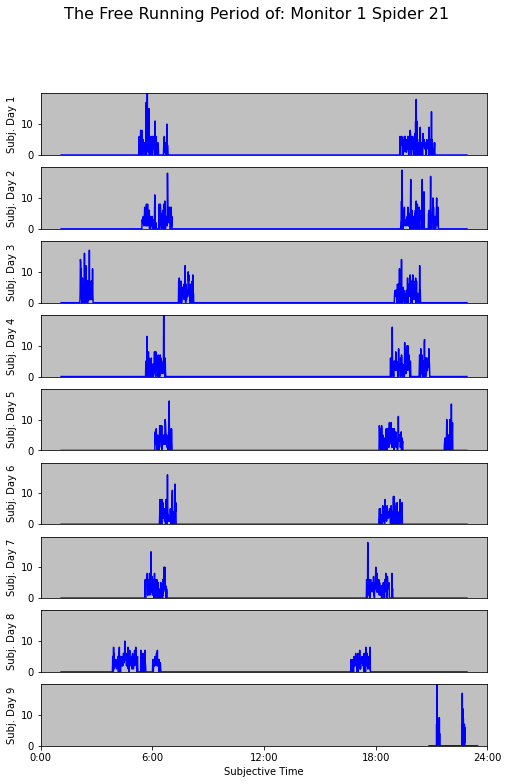

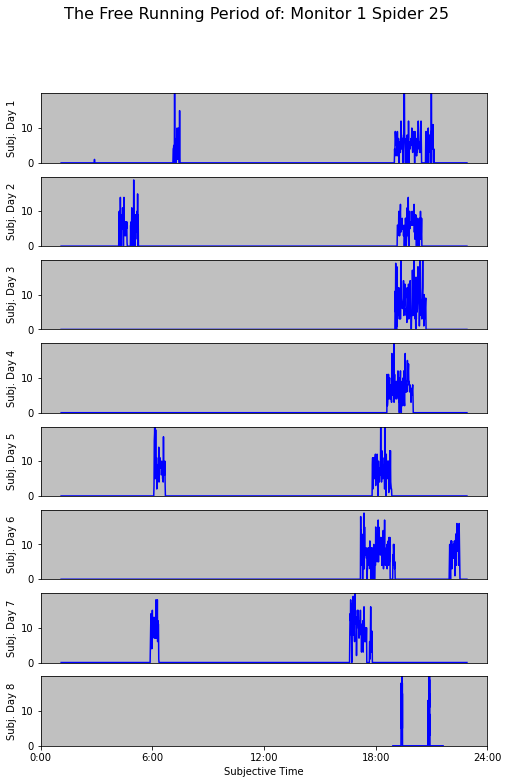

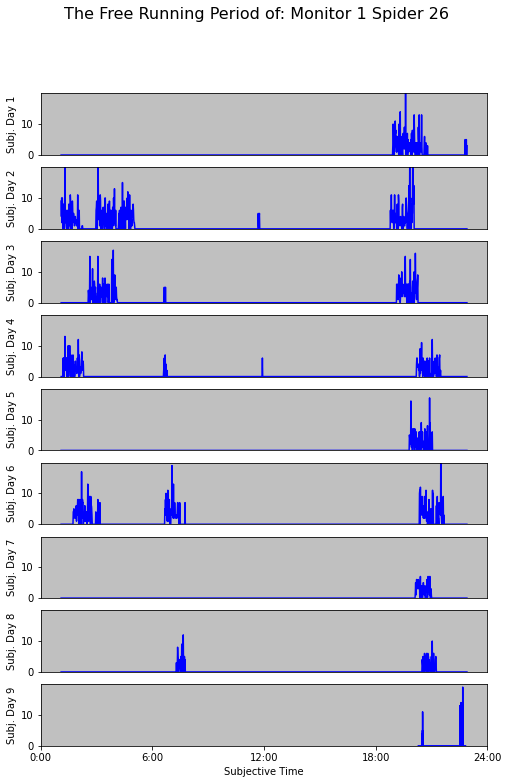

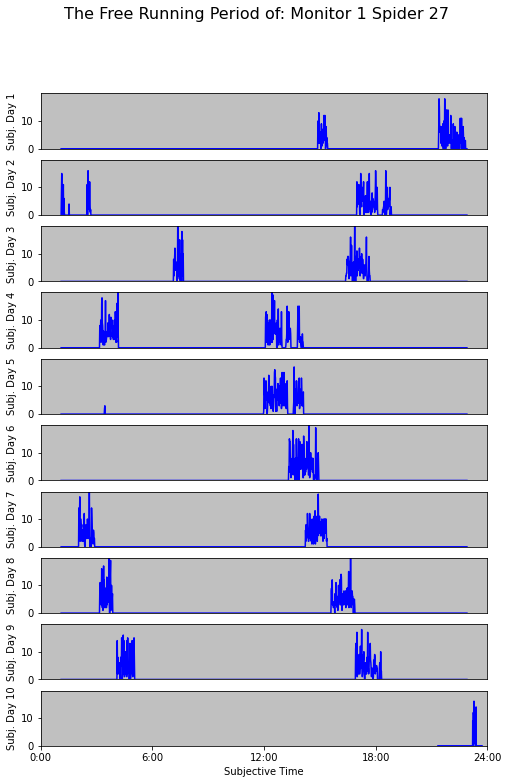

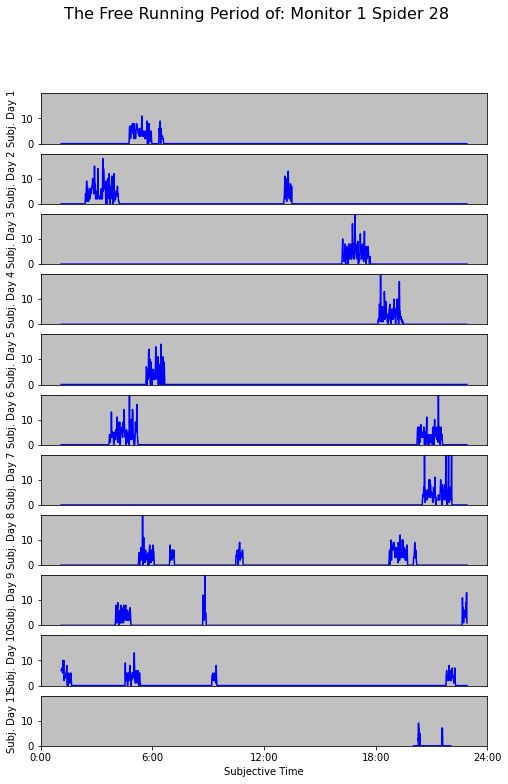

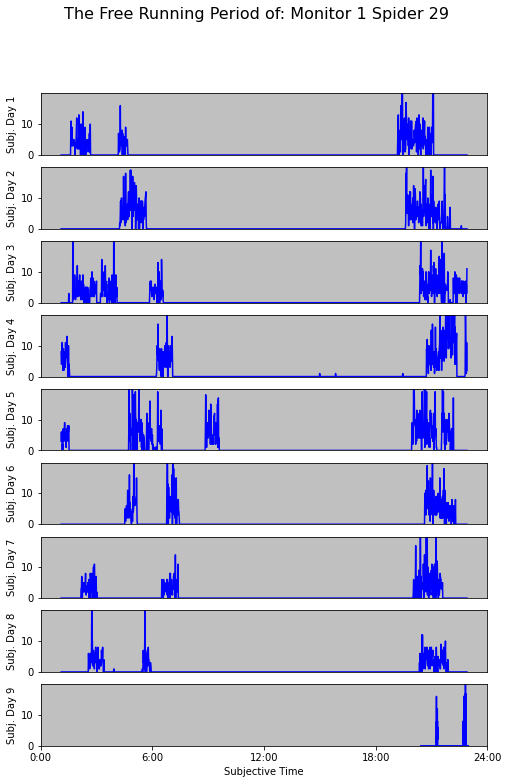

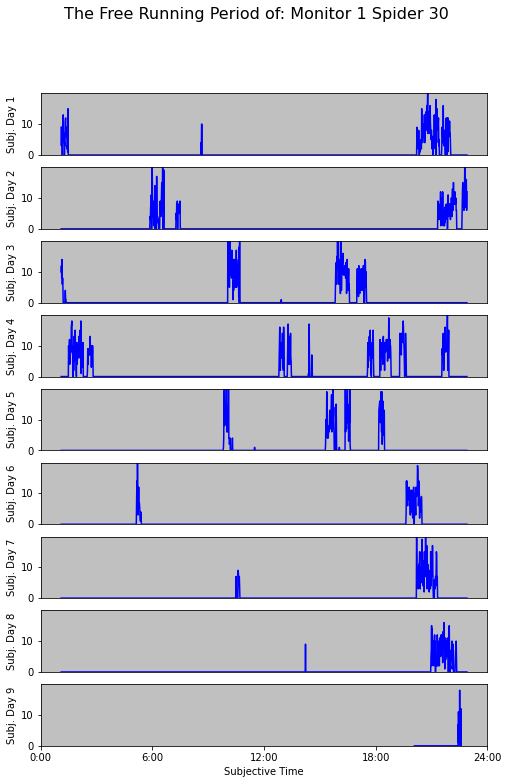

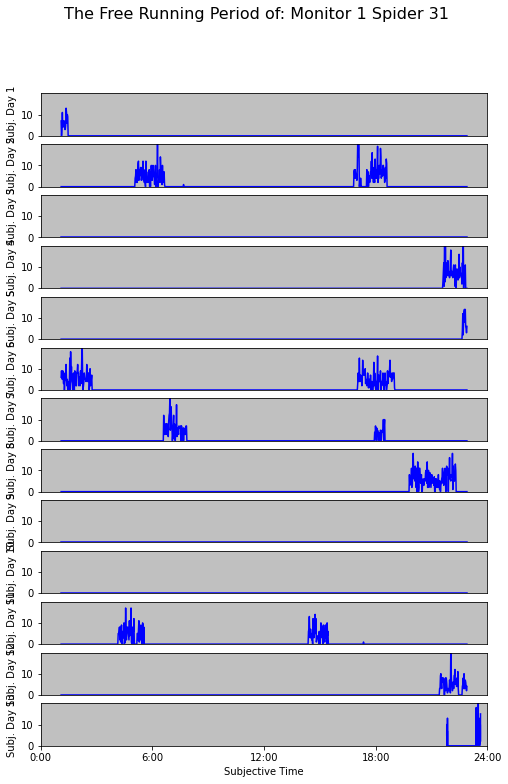

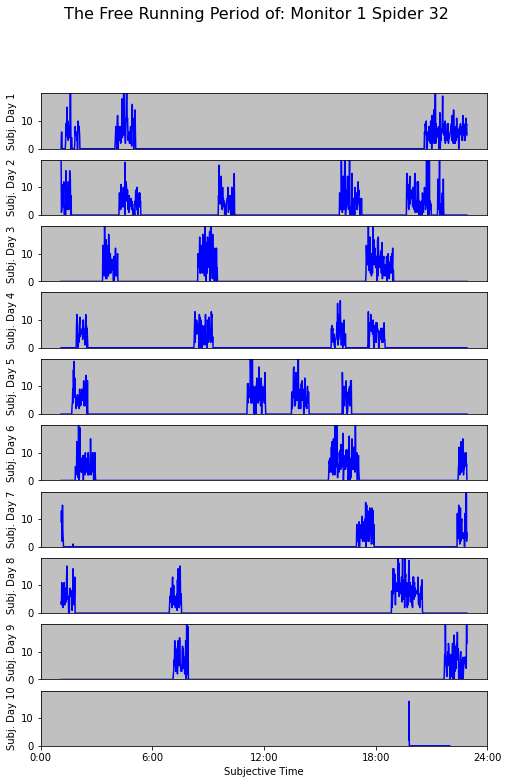

In [28]:
spider_raster(df,perbinary)